In [1]:
library(tidyverse)
library(cowplot)
library(knitr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [2]:
df_eff <- read_csv('effervescence.csv', col_types = 'fffnn')

In [3]:
df_eff %>% head()

Brand,Temp,Stirred,Order,Time
<fct>,<fct>,<fct>,<dbl>,<dbl>
name,6,yes,8,77.21547
name,23,yes,3,75.37855
name,40,yes,7,68.08492
store,6,yes,1,77.87371
store,23,yes,2,66.38436
store,40,yes,18,59.82388


In [4]:
lm_eff <- lm(Time ~ Brand * Temp, data = df_eff)
aov_eff <- aov(lm_eff)
anova_eff <- anova(lm_eff)

In [5]:
me_table <- as_tibble(anova_eff[,1:3])
me_table <- cbind('Source' = c('Brand', 'Temp', 'Brand*Temp', 'Residual'), 
                  me_table, 
                  'Error Term' = c("MSA", "MSB", "MSAB", "MSE"))
me_table

Source,Df,Sum Sq,Mean Sq,Error Term
<chr>,<int>,<dbl>,<dbl>,<chr>
Brand,1,342.0072,342.007154,MSA
Temp,2,1654.7366,827.368276,MSB
Brand*Temp,2,231.8519,115.925956,MSAB
Residual,42,141.1685,3.361154,MSE


In [6]:
me_table <- as_tibble(summary(aov_eff)[[1]][,1:3])
me_table <- cbind('Source' = c('Brand', 'Temp', 'Brand*Temp', 'Residual'), 
                  me_table, 
                  'Error Term' = c("MSA", "MSB", "MSAB", "MSE"))

MSA <-  me_table[1, 4]
MSB <-  me_table[2, 4]
MSAB <- me_table[3, 4]
MSE <-  me_table[4, 4]

a <- length(levels(df_eff$Brand))
b <- length(levels(df_eff$Temp))
n <- nrow(df_eff)/(a*b)

sigma_ab <- (MSAB - MSE) / n
sigma_a <- (MSA - MSAB) / (b * n)
sigma_b <- (MSB - MSAB) / (a*n)

f_scores <- c(MSA/MSAB, MSB/MSAB, MSAB/MSE, NA)

error_dof <- c(rep(tail(me_table$Df, n = 2)[1], 2), tail(me_table$Df, n = 1)[1], NA)

me_table['Error Df'] <- error_dof

me_table["F Score"] <- f_scores
f_test <- round(1 - pf(me_table['F Score'][[1]], 
                       me_table['Df'][[1]], 
                       me_table['Error Df'][[1]]),
                4)

me_table['Pr>F'] <- f_test

se_mu <- sqrt((MSA + MSB - MSAB)/(a * b * n))
dof_app <- (MSA + MSB - MSAB)^2 / (MSA^2/(a-1) + MSB^2/(b-1) + MSAB^2 / ((a-1)*(b-1)))

name_mean <- df_eff %>% filter(Brand == 'name') %>% select(Time) %>% unlist() %>% mean()
brand_fe <- df_eff %>% group_by(Brand) %>% summarise('Mean' = mean(Time), 'Effect' = Mean - name_mean)

name_mean <- df_eff %>% filter(Temp == '6') %>% select(Time) %>% unlist() %>% mean()
temp_fe <- df_eff %>% group_by(Temp) %>% summarise('Mean' = mean(Time), 'Effect' = Mean - name_mean)

knitr::kable(me_table, caption = 'Mixed Effects Models')

knitr::kable(brand_fe, caption = 'Model4: Brand is Fixed and Temperature is Random')
knitr::kable(cbind(c('Temp', 'Brand*Temp', 'Residual'), 
                   c(sigma_b, sigma_ab, MSE)), col.names = c('Cov Parm', 'Estimate'))

knitr::kable(temp_fe, caption = 'Model5: Brand is Random and Temperature is Fixed')
knitr::kable(cbind(c('Brand', 'Brand*Temp', 'Residual'), 
                   c(sigma_a, sigma_ab, MSE)), col.names = c('Cov Parm', 'Estimate'))

knitr::kable(cbind(c('Brand', 'Temp' , 'Brand*Temp', 'Residual'), 
                   c(sigma_a, sigma_b,sigma_ab, MSE)), col.names = c('Cov Parm', 'Estimate'), 
             caption = 'Model6: Brand and Temperature are Random')



Table: Mixed Effects Models

|Source     | Df|    Sum Sq|    Mean Sq|Error Term | Error Df|   F Score|   Pr>F|
|:----------|--:|---------:|----------:|:----------|--------:|---------:|------:|
|Brand      |  1|  342.0072| 342.007154|MSA        |        2|  2.950221| 0.2280|
|Temp       |  2| 1654.7366| 827.368276|MSB        |        2|  7.137041| 0.1229|
|Brand*Temp |  2|  231.8519| 115.925956|MSAB       |       42| 34.489926| 0.0000|
|Residual   | 42|  141.1685|   3.361154|MSE        |       NA|        NA|     NA|



Table: Model4: Brand is Fixed and Temperature is Random

|Brand |     Mean|    Effect|
|:-----|--------:|---------:|
|name  | 73.44276|  0.000000|
|store | 68.10416| -5.338595|



|Cov Parm   |Estimate         |
|:----------|:----------------|
|Temp       |44.4651449693106 |
|Brand*Temp |14.0706002662374 |
|Residual   |3.36115408186724 |



Table: Model5: Brand is Random and Temperature is Fixed

|Temp |     Mean|     Effect|
|:----|--------:|----------:|
|6    | 78.00561|   0.000000|
|23   | 70.69044|  -7.315177|
|40   | 63.62433| -14.381286|



|Cov Parm   |Estimate         |
|:----------|:----------------|
|Brand      |9.42004992022257 |
|Brand*Temp |14.0706002662374 |
|Residual   |3.36115408186724 |



Table: Model6: Brand and Temperature are Random

|Cov Parm   |Estimate         |
|:----------|:----------------|
|Brand      |9.42004992022257 |
|Temp       |44.4651449693106 |
|Brand*Temp |14.0706002662374 |
|Residual   |3.36115408186724 |

In [7]:
sum(c(sigma_a, sigma_b,sigma_ab, MSE))
se_mu
dof_app
CV_hat <- sqrt(sum(c(sigma_a, sigma_b,sigma_ab, MSE)))/mean(df_eff$Time)
CV_hat

[1] 71.31695

[1] 4.684748

[1] 2.381668

[1] 0.1193235

In [8]:
df_nostir <- df_eff %>% filter(Stirred == 'no')

df_aov <- aov(Time ~ Brand * Temp, data = df_nostir)

me_table <- as_tibble(summary(df_aov)[[1]][,1:3])
me_table <- cbind('Source' = c('Brand', 'Temp', 'Brand*Temp', 'Residual'), 
                  me_table, 
                  'Error Term' = c("MSA", "MSB", "MSAB", "MSE"))

MSA <-  me_table[1, 4]
MSB <-  me_table[2, 4]
MSAB <- me_table[3, 4]
MSE <-  me_table[4, 4]

a <- length(levels(df_eff$Brand))
b <- length(levels(df_eff$Temp))
n <- nrow(df_eff)/(a*b)

sigma_ab <- (MSAB - MSE) / n
sigma_a <- (MSA - MSAB) / (b * n)
sigma_b <- (MSB - MSAB) / (a*n)

f_scores <- c(MSA/MSAB,MSB/MSAB,MSAB/MSE, NA)

error_dof <- c(rep(tail(me_table$Df, n = 2)[1], 2), tail(me_table$Df, n = 1)[1], NA)

me_table['Error Df'] <- error_dof

me_table["F Score"] <- f_scores
f_test <- round(1 - pf(me_table['F Score'][[1]], 
                       me_table['Df'][[1]], 
                       me_table['Error Df'][[1]]),
                4)

me_table['Pr>F'] <- f_test



name_mean <- df_eff %>% filter(Brand == 'name') %>% select(Time) %>% unlist() %>% mean()
brand_fe <- df_eff %>% group_by(Brand) %>% summarise('Mean' = mean(Time), 'Effect' = Mean - name_mean)

name_mean <- df_eff %>% filter(Temp == '6') %>% select(Time) %>% unlist() %>% mean()
temp_fe <- df_eff %>% group_by(Temp) %>% summarise('Mean' = mean(Time), 'Effect' = Mean - name_mean)
    


knitr::kable(me_table, caption = 'Mixed Effects Models')

knitr::kable(brand_fe, caption = 'Model4: Brand is Fixed and Temperature is Random')
knitr::kable(cbind(c('Temp', 'Brand*Temp', 'Residual'), 
                   c(sigma_b, sigma_ab, MSE)), col.names = c('Cov Parm', 'Estimate'))

knitr::kable(temp_fe, caption = 'Model5: Brand is Random and Temperature is Fixed')
knitr::kable(cbind(c('Brand', 'Brand*Temp', 'Residual'), 
                   c(sigma_a, sigma_ab, MSE)), col.names = c('Cov Parm', 'Estimate'))

knitr::kable(cbind(c('Brand', 'Temp' , 'Brand*Temp', 'Residual'), 
                   c(sigma_a, sigma_b,sigma_ab, MSE)), col.names = c('Cov Parm', 'Estimate'), 
             caption = 'Model6: Brand and Temperature are Random')



Table: Mixed Effects Models

|Source     | Df|     Sum Sq|     Mean Sq|Error Term | Error Df|    F Score|   Pr>F|
|:----------|--:|----------:|-----------:|:----------|--------:|----------:|------:|
|Brand      |  1| 265.011691| 265.0116910|MSA        |        2|   3.296209| 0.2111|
|Temp       |  2| 838.957737| 419.4788686|MSB        |        2|   5.217468| 0.1608|
|Brand*Temp |  2| 160.797882|  80.3989410|MSAB       |       18| 172.443232| 0.0000|
|Residual   | 18|   8.392216|   0.4662343|MSE        |       NA|         NA|     NA|



Table: Model4: Brand is Fixed and Temperature is Random

|Brand |     Mean|    Effect|
|:-----|--------:|---------:|
|name  | 73.44276|  0.000000|
|store | 68.10416| -5.338595|



|Cov Parm   |Estimate          |
|:----------|:-----------------|
|Temp       |21.1924954718672  |
|Brand*Temp |9.99158834511523  |
|Residual   |0.466234250604435 |



Table: Model5: Brand is Random and Temperature is Fixed

|Temp |     Mean|     Effect|
|:----|--------:|----------:|
|6    | 78.00561|   0.000000|
|23   | 70.69044|  -7.315177|
|40   | 63.62433| -14.381286|



|Cov Parm   |Estimate          |
|:----------|:-----------------|
|Brand      |7.6921979172706   |
|Brand*Temp |9.99158834511523  |
|Residual   |0.466234250604435 |



Table: Model6: Brand and Temperature are Random

|Cov Parm   |Estimate          |
|:----------|:-----------------|
|Brand      |7.6921979172706   |
|Temp       |21.1924954718672  |
|Brand*Temp |9.99158834511523  |
|Residual   |0.466234250604435 |

In [9]:
sum(c(sigma_a, sigma_b,sigma_ab, MSE))

[1] 39.34252

In [10]:
df_stir <- df_eff %>% filter(Stirred == 'yes')

df_aov <- aov(Time ~ Brand * Temp, data = df_stir)

me_table <- as_tibble(summary(df_aov)[[1]][,1:3])
me_table <- cbind('Source' = c('Brand', 'Temp', 'Brand*Temp', 'Residual'), 
                  me_table, 
                  'Error Term' = c("MSA", "MSB", "MSAB", "MSE"))

MSA <-  me_table[1, 4]
MSB <-  me_table[2, 4]
MSAB <- me_table[3, 4]
MSE <-  me_table[4, 4]

a <- length(levels(df_eff$Brand))
b <- length(levels(df_eff$Temp))
n <- nrow(df_eff)/(a*b)

sigma_ab <- (MSAB - MSE) / n
sigma_a <- (MSA - MSAB) / (b * n)
sigma_b <- (MSB - MSAB) / (a*n)

f_scores <- c(MSA/MSAB,MSB/MSAB,MSAB/MSE, NA)

error_dof <- c(rep(tail(me_table$Df, n = 2)[1], 2), tail(me_table$Df, n = 1)[1], NA)

me_table['Error Df'] <- error_dof

me_table["F Score"] <- f_scores
f_test <- round(1 - pf(me_table['F Score'][[1]], 
                       me_table['Df'][[1]], 
                       me_table['Error Df'][[1]]),
                4)

me_table['Pr>F'] <- f_test



name_mean <- df_eff %>% filter(Brand == 'name') %>% select(Time) %>% unlist() %>% mean()
brand_fe <- df_eff %>% group_by(Brand) %>% summarise('Mean' = mean(Time), 'Effect' = Mean - name_mean)

name_mean <- df_eff %>% filter(Temp == '6') %>% select(Time) %>% unlist() %>% mean()
temp_fe <- df_eff %>% group_by(Temp) %>% summarise('Mean' = mean(Time), 'Effect' = Mean - name_mean)
    


knitr::kable(me_table, caption = 'Mixed Effects Models')

knitr::kable(brand_fe, caption = 'Model4: Brand is Fixed and Temperature is Random')
knitr::kable(cbind(c('Temp', 'Brand*Temp', 'Residual'), 
                   c(sigma_b, sigma_ab, MSE)), col.names = c('Cov Parm', 'Estimate'))

knitr::kable(temp_fe, caption = 'Model5: Brand is Random and Temperature is Fixed')
knitr::kable(cbind(c('Brand', 'Brand*Temp', 'Residual'), 
                   c(sigma_a, sigma_ab, MSE)), col.names = c('Cov Parm', 'Estimate'))

knitr::kable(cbind(c('Brand', 'Temp' , 'Brand*Temp', 'Residual'), 
                   c(sigma_a, sigma_b,sigma_ab, MSE)), col.names = c('Cov Parm', 'Estimate'), 
             caption = 'Model6: Brand and Temperature are Random')



Table: Mixed Effects Models

|Source     | Df|    Sum Sq|    Mean Sq|Error Term | Error Df|   F Score|   Pr>F|
|:----------|--:|---------:|----------:|:----------|--------:|---------:|------:|
|Brand      |  1|  97.50550|  97.505504|MSA        |        2|  2.434286| 0.2591|
|Temp       |  2| 815.90352| 407.951760|MSB        |        2| 10.184770| 0.0894|
|Brand*Temp |  2|  80.11016|  40.055078|MSAB       |       18| 21.718234| 0.0000|
|Residual   | 18|  33.19752|   1.844306|MSE        |       NA|        NA|     NA|



Table: Model4: Brand is Fixed and Temperature is Random

|Brand |     Mean|    Effect|
|:-----|--------:|---------:|
|name  | 73.44276|  0.000000|
|store | 68.10416| -5.338595|



|Cov Parm   |Estimate         |
|:----------|:----------------|
|Temp       |22.9935426086442 |
|Brand*Temp |4.77634650025858 |
|Residual   |1.84430644204827 |



Table: Model5: Brand is Random and Temperature is Fixed

|Temp |     Mean|     Effect|
|:----|--------:|----------:|
|6    | 78.00561|   0.000000|
|23   | 70.69044|  -7.315177|
|40   | 63.62433| -14.381286|



|Cov Parm   |Estimate         |
|:----------|:----------------|
|Brand      |2.393767732355   |
|Brand*Temp |4.77634650025858 |
|Residual   |1.84430644204827 |



Table: Model6: Brand and Temperature are Random

|Cov Parm   |Estimate         |
|:----------|:----------------|
|Brand      |2.393767732355   |
|Temp       |22.9935426086442 |
|Brand*Temp |4.77634650025858 |
|Residual   |1.84430644204827 |

In [11]:
sum(c(sigma_a, sigma_b,sigma_ab, MSE))

[1] 32.00796

In [12]:
library(car)
Anova(lm(Time ~ Temp + Brand * Stirred, data = df_eff), type = 3)

Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


The following object is masked from ‘package:purrr’:

    some




,Sum Sq,Df,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),49693.91326,1,7384.919898,7.765287e-49
Temp,1654.73655,2,122.953659,2.779255e-18
Brand,97.50550,1,14.490111,4.517511e-04
Stirred,83.05926,1,12.343282,1.073633e-03
Brand:Stirred,20.51004,1,3.047959,8.815069e-02
Residuals,282.62248,42,NA,NA


In [13]:
mean(df_eff$Time)
var(df_eff$Time)

[1] 70.77346

[1] 50.42051

In [14]:
df_eff %>% filter(Brand == 'name') %>% select(Time) %>% unlist() %>% unname() %>% mean()
df_eff %>% filter(Brand == 'store') %>% select(Time) %>% unlist() %>% unname() %>% mean()

[1] 73.44276

[1] 68.10416

In [15]:
df_eff %>% group_by(Brand) %>% summarise('Mean' = mean(Time), 'Var' = var(Time))
df_eff %>% group_by(Stirred) %>% summarise('Mean' = mean(Time), 'Var' = var(Time))
df_eff %>% group_by(Temp) %>% summarise('Mean' = mean(Time), 'Var' = var(Time))

Brand,Mean,Var
<fct>,<dbl>,<dbl>
name,73.44276,21.13144
store,68.10416,67.03190


Stirred,Mean,Var
<fct>,<dbl>,<dbl>
yes,69.56681,44.63986
no,71.98011,55.35476


Temp,Mean,Var
<fct>,<dbl>,<dbl>
6,78.00561,2.467426
23,70.69044,19.204515
40,63.62433,25.996561


In [16]:
means_nostir <- df_eff %>% filter(Stirred == "no") %>% group_by(Brand, Temp) %>% summarise('Mean' = mean(Time))
means_nostir <- means_nostir %>% pivot_wider(names_from = Brand, values_from = Mean)
#means_nostir$TempMean <- rowMeans(means_nostir[,2:3])
#means_nostir <- cbind('Temp' = c('6', '23', '40', 'BrandMean'),rbind(means_nostir[,2:4], colMeans(means_nostir[,2:4])))
means_nostir

`summarise()` has grouped output by 'Brand'. You can override using the
`.groups` argument.


Temp,name,store
<fct>,<dbl>,<dbl>
6,78.99061,79.49240
23,76.36351,67.51552
40,70.55511,58.96347


In [17]:
means_stir <- df_eff %>% filter(Stirred == "yes") %>% group_by(Brand, Temp) %>% summarise('Mean' = mean(Time))
means_stir <- means_stir %>% pivot_wider(names_from = Brand, values_from = Mean)
means_stir$TempMean <- rowMeans(means_stir[,2:3])
means_stir <- cbind('Temp' = c('6', '23', '40', 'BrandMean'),rbind(means_stir[,2:4], colMeans(means_stir[,2:4])))
means_stir

`summarise()` has grouped output by 'Brand'. You can override using the
`.groups` argument.


Temp,name,store,TempMean
<chr>,<dbl>,<dbl>,<dbl>
6,76.20241,77.33703,76.76972
23,72.69145,66.19126,69.44135
40,65.85343,59.12529,62.48936
BrandMean,71.58243,67.55119,69.56681


In [18]:
means_table <- df_eff %>% group_by(Brand, Temp) %>% summarise('Mean' = mean(Time))
means_table <- means_table %>% pivot_wider(names_from = Brand, values_from = Mean)
means_table$TempMean <- rowMeans(means_table[,2:3])
means_table <- cbind('Temp' = c('6', '23', '40', 'BrandMean'),rbind(means_table[,2:4], colMeans(means_table[,2:4])))
knitr::kable(means_table)

`summarise()` has grouped output by 'Brand'. You can override using the
`.groups` argument.




|Temp      |     name|    store| TempMean|
|:---------|--------:|--------:|--------:|
|6         | 77.59651| 78.41471| 78.00561|
|23        | 74.52748| 66.85339| 70.69044|
|40        | 68.20427| 59.04438| 63.62433|
|BrandMean | 73.44276| 68.10416| 70.77346|

In [19]:
# Random effect Analysis
re_table <- as_tibble(cbind(c('Brand', 'Temp' , 'Brand*Temp', 'Residual'), round(c(sigma_a, sigma_b,sigma_ab, MSE), 4))) 
colnames(re_table) <- c('Cov Parm', 'Estimate')
re_table$Estimate <- as.numeric(re_table$Estimate)
re_table$Portion <- round(as.numeric(re_table$Estimate) / sum(as.numeric(re_table$Estimate)),3)
re_table

Warning message:
“The `x` argument of `as_tibble.matrix()` must have unique column names if `.name_repair` is omitted as of tibble 2.0.0.
Using compatibility `.name_repair`.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was generated.”


Cov Parm,Estimate,Portion
<chr>,<dbl>,<dbl>
Brand,2.3938,0.075
Temp,22.9935,0.718
Brand*Temp,4.7763,0.149
Residual,1.8443,0.058


In [20]:
re_table$Estimate <- as.numeric(re_table$Estimate)
re_table$Percent <- round(as.numeric(re_table$Estimate) / sum(as.numeric(re_table$Estimate)),3)

In [21]:
re_table

Cov Parm,Estimate,Portion,Percent
<chr>,<dbl>,<dbl>,<dbl>
Brand,2.3938,0.075,0.075
Temp,22.9935,0.718,0.718
Brand*Temp,4.7763,0.149,0.149
Residual,1.8443,0.058,0.058


In [22]:
se_mu

[1] 4.684748

In [23]:
means_table %>% mutate('Diff' = name - store)

Temp,name,store,TempMean,Diff
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
6,77.59651,78.41471,78.00561,-0.8181992
23,74.52748,66.85339,70.69044,7.6740900
40,68.20427,59.04438,63.62433,9.1598941
BrandMean,73.44276,68.10416,70.77346,5.3385950


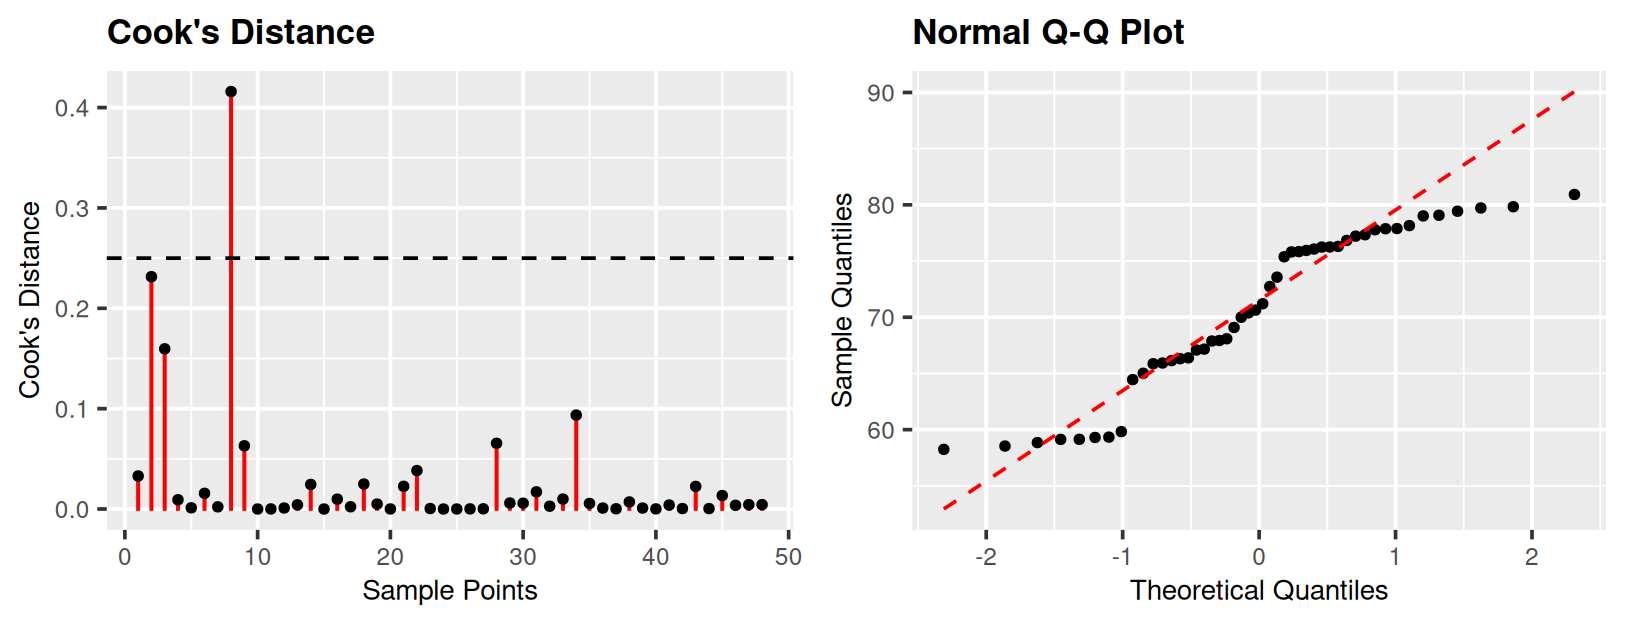

In [24]:
options(repr.plot.width = 6.5, repr.plot.height = 2.5, repr.plot.res = 250)

aov_eff <- aov(lm_eff <- lm(Time ~ Brand * Temp * Stirred, data = df_eff))

cooksD_values <- cooks.distance(lm_eff)
 
CD_plot <- ggplot() + 
  geom_col(aes(y = cooksD_values, x = 1:length(cooksD_values)), 
  width = 0.025, col = 'red')  + 
  geom_point(aes(y = cooksD_values, x = 1:length(cooksD_values)), shape = 20) + 
  xlab('Sample Points') + ylab("Cook's Distance") + 
  geom_hline(yintercept = 0.25, lty = 2) + 
  labs(title = "Cook's Distance") + 
  theme(
      plot.title = element_text(size = 10, face = "bold"),
      axis.text = element_text(size = 7),
      axis.title = element_text(size = 8)
)

#CD_plot <- ols_plot_cooksd_chart(lm_eff)
qqplot1 <- ggplot(df_eff, aes(sample = Time)) + 
  stat_qq(shape = 20) + 
  stat_qq_line(linetype = "dashed", col = 'red') + 
  labs(x = "Theoretical Quantiles", 
       y = "Sample Quantiles", 
       title = "Normal Q-Q Plot") + 
  theme(
      plot.title = element_text(size = 10, face = "bold"),
      axis.text = element_text(size = 7),
      axis.title = element_text(size = 8)
)

plot_grid(CD_plot, qqplot1)

In [25]:
df_eff %>% group_by(Brand) %>% summarise('Mean' = mean(Time), 'Var' = var(Time),'Max' = max(Time), 'Min' = min(Time), 'Spread' = Max - Min) %>% kable()
df_eff %>% group_by(Temp) %>% summarise('Mean' = mean(Time), 'Var' = var(Time), 'Max' = max(Time), 'Min' = min(Time), 'Spread' = Max - Min) %>% kable()
df_eff %>% group_by(Brand, Temp) %>% summarise('Mean' = mean(Time), 'Var' = var(Time), 'Max' = max(Time), 'Min' = min(Time), 'Spread' = Max - Min) %>% kable()
df_eff %>% group_by(Brand, Stirred) %>% summarise('Mean' = mean(Time), 'Var' = var(Time), 'Max' = max(Time), 'Min' = min(Time), 'Spread' = Max - Min) %>% kable()
df_eff %>% group_by(Temp, Stirred) %>% summarise('Mean' = mean(Time), 'Var' = var(Time), 'Max' = max(Time), 'Min' = min(Time), 'Spread' = Max - Min) %>% kable()



|Brand |     Mean|      Var|      Max|      Min|   Spread|
|:-----|--------:|--------:|--------:|--------:|--------:|
|name  | 73.44276| 21.13144| 79.72130| 64.45156| 15.26973|
|store | 68.10416| 67.03190| 80.92176| 58.24407| 22.67769|



|Temp |     Mean|       Var|      Max|      Min|    Spread|
|:----|--------:|---------:|--------:|--------:|---------:|
|6    | 78.00561|  2.467426| 80.92176| 75.80973|  5.112037|
|23   | 70.69044| 19.204515| 76.83265| 65.92809| 10.904559|
|40   | 63.62433| 25.996561| 71.20207| 58.24407| 12.958001|

`summarise()` has grouped output by 'Brand'. You can override using the
`.groups` argument.




|Brand |Temp |     Mean|       Var|      Max|      Min|   Spread|
|:-----|:----|--------:|---------:|--------:|--------:|--------:|
|name  |6    | 77.59651| 2.5957290| 79.72130| 75.80973| 3.911567|
|name  |23   | 74.52748| 6.8931729| 76.83265| 69.08937| 7.743272|
|name  |40   | 68.20427| 7.5178162| 71.20207| 64.45156| 6.750513|
|store |6    | 78.41471| 2.3090692| 80.92176| 76.24402| 4.677741|
|store |23   | 66.85339| 0.6069845| 67.93138| 65.92809| 2.003292|
|store |40   | 59.04438| 0.2441527| 59.82388| 58.24407| 1.579810|

`summarise()` has grouped output by 'Brand'. You can override using the
`.groups` argument.




|Brand |Stirred |     Mean|      Var|      Max|      Min|    Spread|
|:-----|:-------|--------:|--------:|--------:|--------:|---------:|
|name  |yes     | 71.58243| 22.87009| 77.21547| 64.45156| 12.763904|
|name  |no      | 75.30308| 13.76300| 79.72130| 69.99943|  9.721863|
|store |yes     | 67.55119| 61.60366| 77.89089| 58.24407| 19.646821|
|store |no      | 68.65713| 77.88680| 80.92176| 58.53920| 22.382569|

`summarise()` has grouped output by 'Temp'. You can override using the
`.groups` argument.




|Temp |Stirred |     Mean|        Var|      Max|      Min|    Spread|
|:----|:-------|--------:|----------:|--------:|--------:|---------:|
|6    |yes     | 76.76972|  0.8203152| 77.89089| 75.80973|  2.081166|
|6    |no      | 79.24151|  0.9757520| 80.92176| 77.78345|  3.138317|
|23   |yes     | 69.44135| 15.0841513| 75.37855| 65.92809|  9.450466|
|23   |no      | 71.93952| 22.5021998| 76.83265| 67.08353|  9.749120|
|40   |yes     | 62.48936| 14.2117017| 68.08492| 58.24407|  9.840843|
|40   |no      | 64.75929| 38.5508753| 71.20207| 58.53920| 12.662879|

In [26]:
options(repr.plot.width = 6.5, repr.plot.height = 2.5, repr.plot.res = 250)

change_var <-
df_eff %>% group_by(Brand, Temp) %>% summarise('Mean' = mean(Time), 
                                               'Var' = var(Time), 
                                               'Max' = max(Time), 
                                               'Min' = min(Time), 
                                               'Spread' = Max - Min)
change_varplot <-
ggplot(change_var) + geom_point(aes(x = Temp, y = Var, col = Brand)) +
                     geom_line(aes(x = Temp, y = Var, col = Brand, group = Brand)) + 
                     labs(title = "Change in Variance over Temperature",
                          x = 'Temperature in Celsius',
                          y = 'Variance') +
                     theme(legend.position = c(0.9, 0.5),
                           plot.title = element_text(size = 10, face = "bold"),
                           axis.text = element_text(size = 7),
                           axis.title = element_text(size = 8))


`summarise()` has grouped output by 'Brand'. You can override using the
`.groups` argument.


In [27]:
options(repr.plot.width = 6.5, repr.plot.height = 2.5, repr.plot.res = 250)

change_var2 <-
df_eff %>% filter(Stirred == "yes") %>% group_by(Brand, Temp) %>% summarise('Mean' = mean(Time), 
                                               'Var' = var(Time), 
                                               'Max' = max(Time), 
                                               'Min' = min(Time), 
                                               'Spread' = Max - Min)
change_var2plot <-
ggplot(change_var2) + geom_point(aes(x = Temp, y = Var, col = Brand)) +
                     geom_line(aes(x = Temp, y = Var, col = Brand, group = Brand)) + 
                     labs(title = "Change in Variance over Temperature (Stirred)",
                          x = 'Temperature in Celsius',
                          y = 'Variance') +
                     theme(legend.position = c(0.9, 0.5),
                           plot.title = element_text(size = 10, face = "bold"),
                           axis.text = element_text(size = 7),
                           axis.title = element_text(size = 8))

`summarise()` has grouped output by 'Brand'. You can override using the
`.groups` argument.


`summarise()` has grouped output by 'Brand'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'Brand'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'Brand'. You can override using the
`.groups` argument.


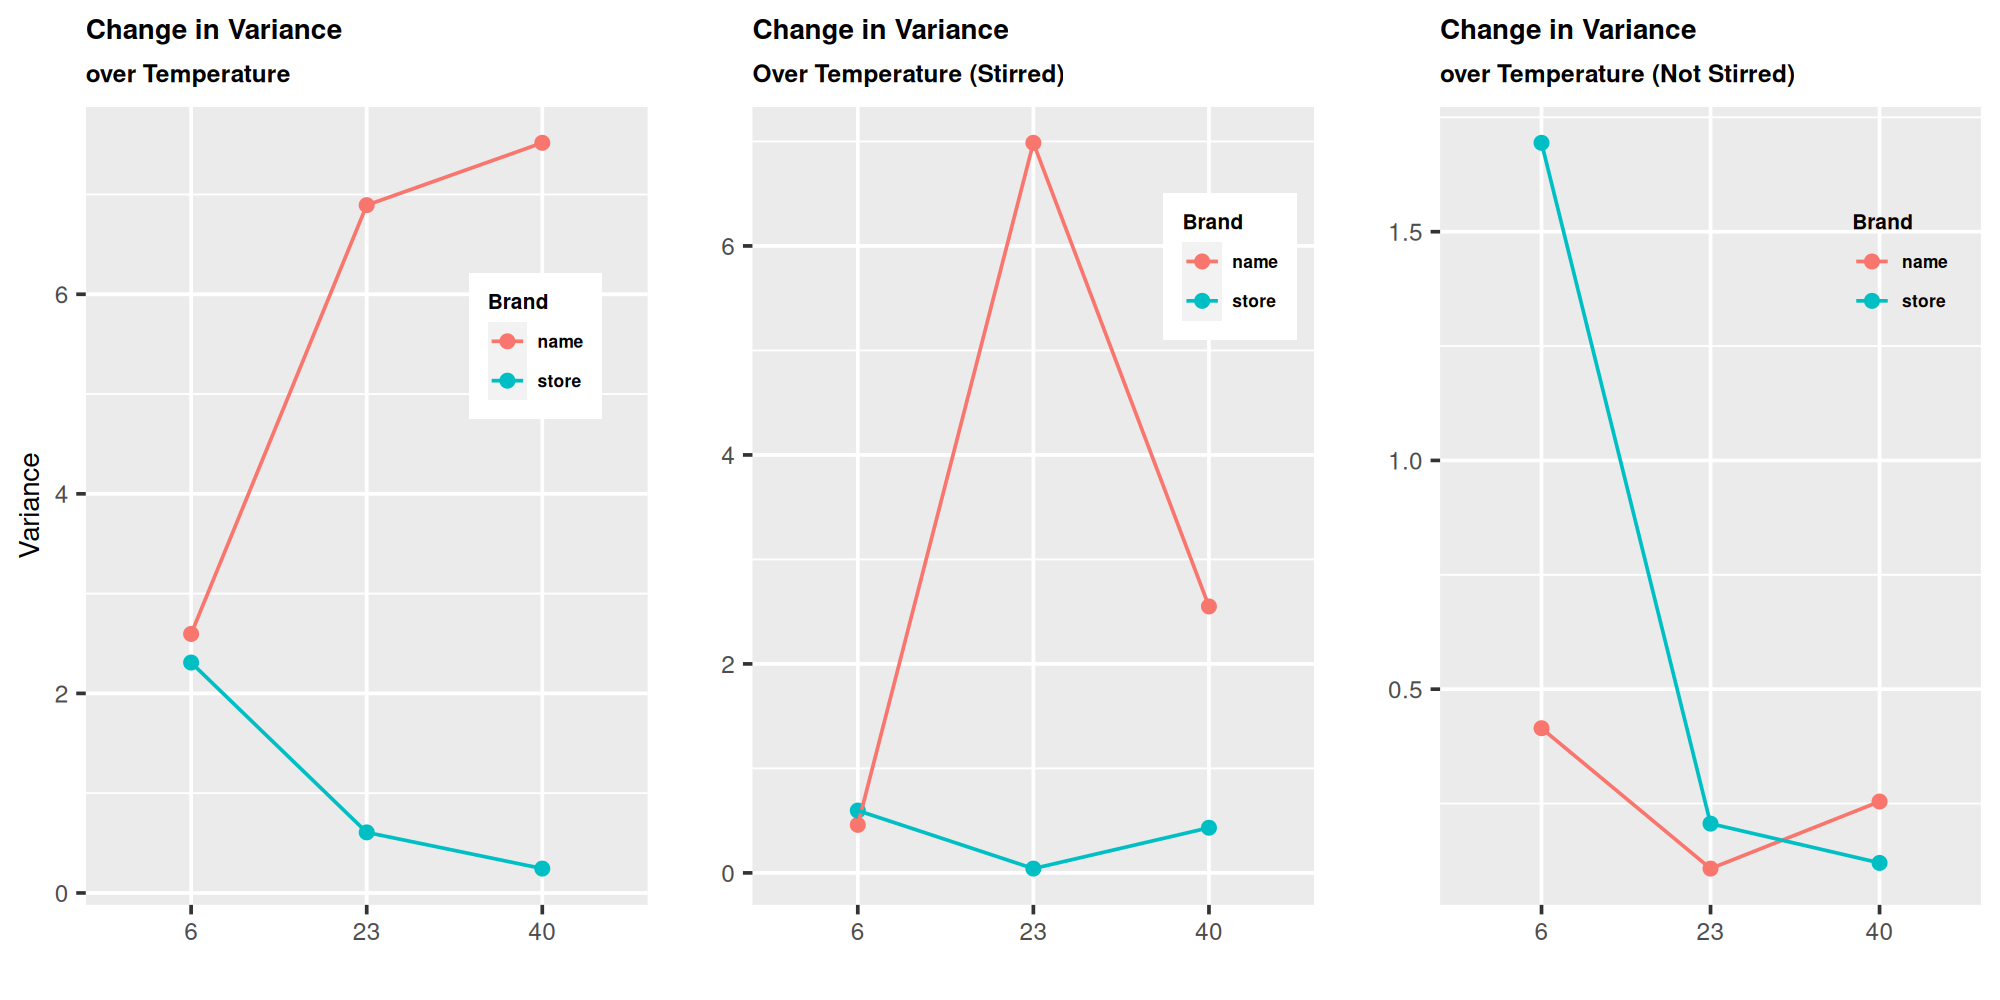

In [28]:
options(repr.plot.width = 8, repr.plot.height = 4, repr.plot.res = 250)

change_var <-
df_eff %>% group_by(Brand, Temp) %>% summarise('Mean' = mean(Time), 
                                               'Var' = var(Time), 
                                               'Max' = max(Time), 
                                               'Min' = min(Time), 
                                               'Spread' = Max - Min)
change_varplot <-
ggplot(change_var) + geom_point(aes(x = Temp, y = Var, col = Brand)) +
                     geom_line(aes(x = Temp, y = Var, col = Brand, group = Brand)) + 
                     labs(title = "Change in Variance",
                          subtitle = "over Temperature",
                          x = '',
                          y = 'Variance') +
                     theme(legend.position = c(0.8, 0.7),
                           plot.title = element_text(size = 8, face = "bold"),
                           plot.subtitle = element_text(size = 7, face = "bold"),
                           axis.text = element_text(size = 7),
                           axis.title = element_text(size = 8),
                           legend.text = element_text(size=5, face="bold"),
                           legend.title = element_text(size=6, face="bold"),
                           legend.key.size = unit(0.4, 'cm'))

change_var2 <-
df_eff %>% filter(Stirred == "yes") %>% group_by(Brand, Temp) %>% summarise('Mean' = mean(Time), 
                                               'Var' = var(Time), 
                                               'Max' = max(Time), 
                                               'Min' = min(Time), 
                                               'Spread' = Max - Min)
change_var2plot <-
ggplot(change_var2) + geom_point(aes(x = Temp, y = Var, col = Brand)) +
                     geom_line(aes(x = Temp, y = Var, col = Brand, group = Brand)) + 
                     labs(title = "Change in Variance",
                          subtitle = "Over Temperature (Stirred)",
                          x = '',
                          y = '') +
                     theme(legend.position = c(0.85, 0.8),
                           plot.title = element_text(size = 8, face = "bold"),
                           plot.subtitle = element_text(size = 7, face = "bold"),
                           axis.text = element_text(size = 7),
                           axis.title = element_text(size = 8),
                           legend.text = element_text(size=5, face="bold"),
                           legend.title = element_text(size=6, face="bold"),
                           legend.key.size = unit(0.4, 'cm'))

change_var3 <-
df_eff %>% filter(Stirred == "no") %>% group_by(Brand, Temp) %>% summarise('Mean' = mean(Time), 
                                               'Var' = var(Time), 
                                               'Max' = max(Time), 
                                               'Min' = min(Time), 
                                               'Spread' = Max - Min)
change_var3plot <-
ggplot(change_var3) + geom_point(aes(x = Temp, y = Var, col = Brand)) +
                     geom_line(aes(x = Temp, y = Var, col = Brand, group = Brand)) + 
                     labs(title = "Change in Variance",
                          subtitle = "over Temperature (Not Stirred)",
                          x = '',
                          y = '') +
                     theme(legend.position = c(0.85, 0.8),
                           plot.title = element_text(size = 8, face = "bold"),
                           plot.subtitle = element_text(size = 7, face = "bold"),
                           axis.text = element_text(size = 7),
                           axis.title = element_text(size = 8),
                           legend.text = element_text(size=5, face="bold"),
                           legend.title = element_text(size=6, face="bold"),
                           legend.key.size = unit(0.4, 'cm'),
                           legend.key = element_rect(colour = "transparent", fill = alpha("white", 0)),
                           legend.background = element_rect(fill = alpha("white", 0)))

plot_grid(change_varplot,change_var2plot,change_var3plot, ncol = 3)

In [29]:
aov_eff <- aov(lm_eff <- lm(Time ~ Brand * Temp * Stirred, data = df_eff))
aov_block_eff <- aov(lm_block_eff <- lm(Time ~ Brand * Temp + Stirred, data = df_eff))
aov_block_eff_noint <- aov(lm_block_eff <- lm(Time ~ Brand + Temp + Stirred, data = df_eff))
aov_block_order_eff <- aov(lm_block_order_eff <- lm(Time ~ Brand * Temp + Stirred + Order, data = df_eff))
aov_three_order_eff <- aov(lm_three_order_eff <- lm(Time ~ Brand * Temp * Stirred + Order, data = df_eff))


RMSE_function <- function(df_aov){
    
    r_mse <- sqrt(sum(df_aov$residuals^2)/df_aov$df)
    
    r_s <- 1 - tail(summary(df_aov)[1][[1]][[2]], n = 1) / sum(summary(df_aov)[1][[1]][2])

    a_r_s <- 1 - (1 - r_s)*(nrow(df_aov$model) - 1)/(df_aov$df)
    
    aic_ <- AIC(df_aov)
    
    bic_ <- BIC(df_aov)
    
    output_stats <- c(
        r_mse,
        r_s,
        a_r_s,
        aic_,
        bic_
    )
    return(output_stats)
}


model1 <- RMSE_function(aov_eff)
model2 <- RMSE_function(aov_block_eff)
model3 <- RMSE_function(aov_block_eff_noint)
model7 <- RMSE_function(aov_block_order_eff)
model8 <- RMSE_function(aov_three_order_eff)

d <- rbind(model1, model2, model3, model7, model8)
colnames(d) <- c('Root MSE', '$R^2$', 'adj $R^2$', 'AIC', 'BIC')
kable(d, escape = FALSE, align = "lccrr")#, col.names = c('Model', 'Root MSE', 'R^2', 'adj R^2', 'AIC', 'BIC'))



|       |Root MSE |   $R^2$   | adj $R^2$ |      AIC|      BIC|
|:------|:--------|:---------:|:---------:|--------:|--------:|
|model1 |1.074835 | 0.9824498 | 0.9770873 | 155.3374| 179.6630|
|model2 |1.318541 | 0.9699208 | 0.9655190 | 171.1984| 186.1680|
|model3 |2.655107 | 0.8720833 | 0.8601840 | 236.6806| 247.9078|
|model7 |1.302961 | 0.9713439 | 0.9663290 | 170.8720| 187.7129|
|model8 |1.086887 | 0.9825525 | 0.9765706 | 157.0557| 183.2525|

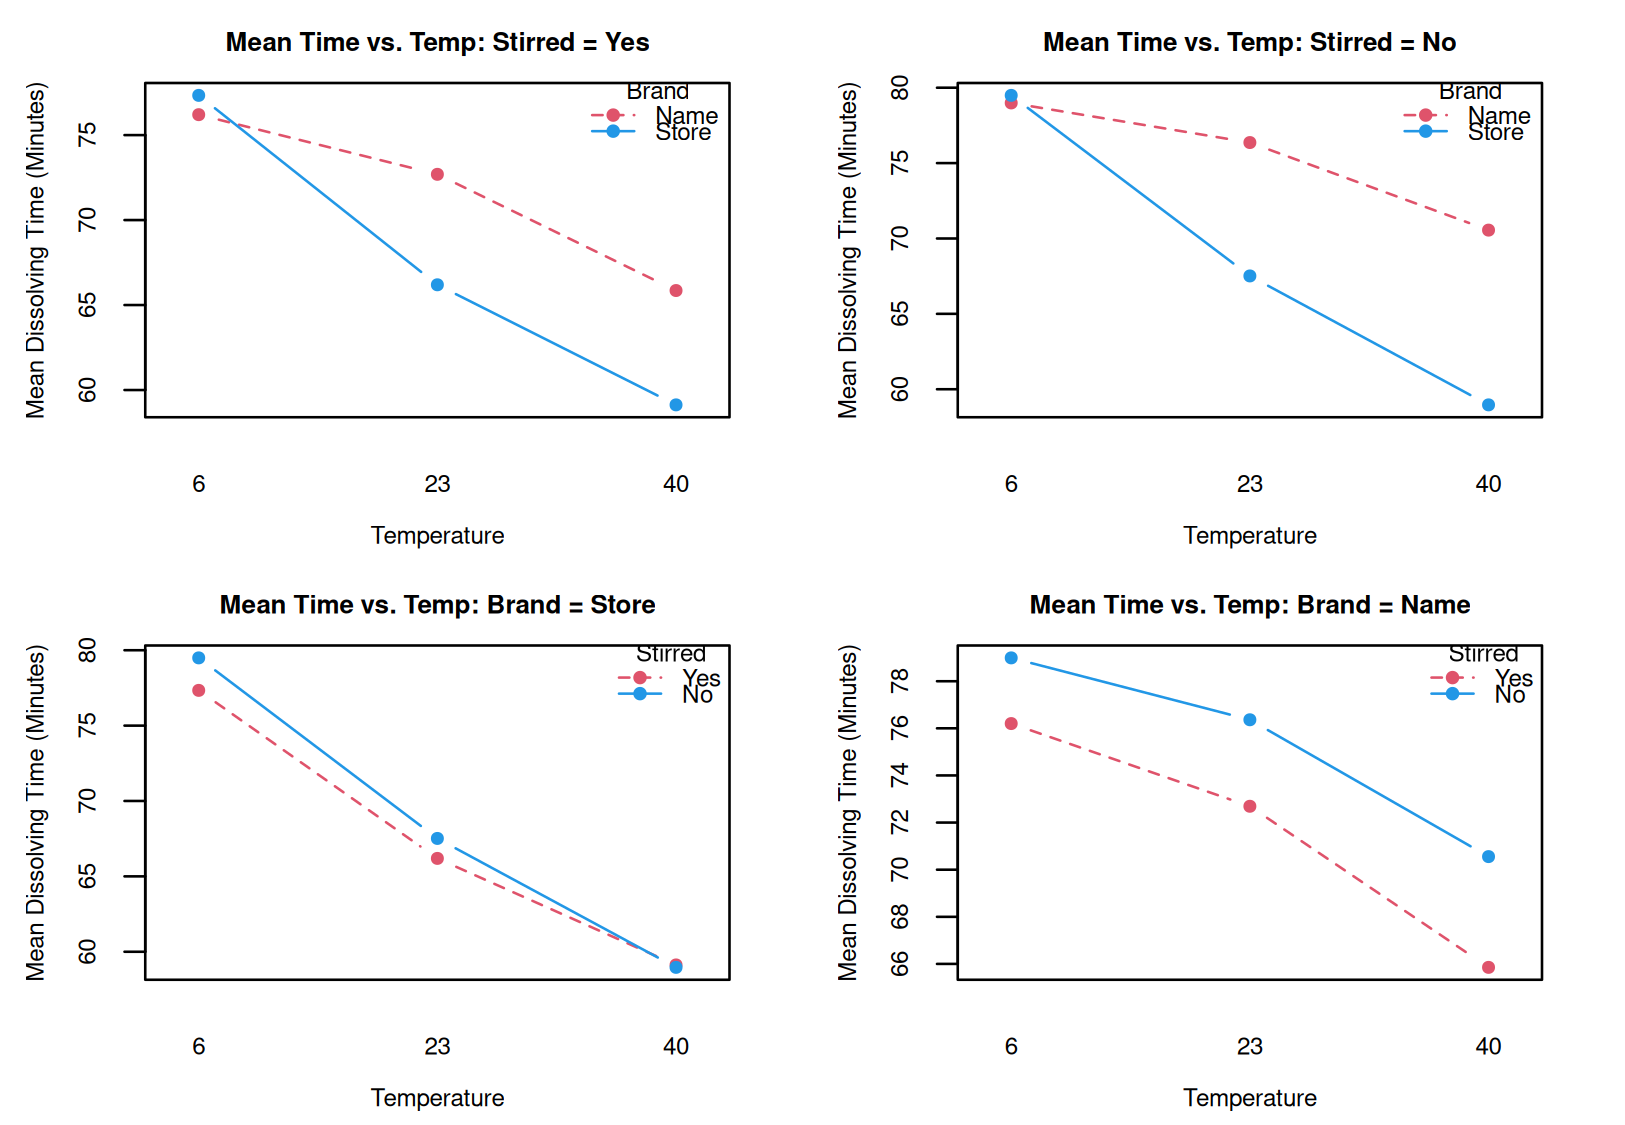

In [30]:
options(repr.plot.width = 6.5, repr.plot.height = 4.5, repr.plot.res = 250)
par(mfrow=c(2,2), mar = c(3.5,3.5,2,2))
with(df_eff%>%filter(Stirred=="yes"),interaction.plot(Temp,Brand,Time,
            type="b", pch=20, col=c(2,4), ylab="", xlab = "",
            main="Mean Time vs. Temp: Stirred = Yes", 
            cex.main = 0.75, cex.axis = 0.7, legend = FALSE))
legend("topright",
       title = "Brand",
       c("Name", "Store"),
       bty = "n",
       cex = 0.7,
       col = c("#DF536B","#2297E6"),
       pch = c(19,19), lty = c(2,1))
title(xlab = "Temperature", ylab = "Mean Dissolving Time (Minutes)", line = 2.25, cex.lab = 0.7)

with(df_eff%>%filter(Stirred=="no"),interaction.plot(Temp,Brand,Time,
          type="b", pch=20, col=c(2,4), ylab="", xlab = "",
          main="Mean Time vs. Temp: Stirred = No", 
          cex.main = 0.75, cex.axis = 0.7, legend = FALSE))
legend("topright",
       title = "Brand",
       c("Name", "Store"),
       bty = "n",
       cex = 0.7,
       col = c("#DF536B","#2297E6"),
       pch = c(19,19), lty = c(2,1))
title(xlab = 'Temperature', ylab = "Mean Dissolving Time (Minutes)", line = 2.25, cex.lab = 0.7)
with(df_eff%>%filter(Brand=="store"),interaction.plot(Temp,Stirred,Time,
            type="b", pch=20, col=c(2,4), ylab="", xlab = "",
            main="Mean Time vs. Temp: Brand = Store", 
            cex.main = 0.75, cex.axis = 0.7, legend = FALSE))
legend("topright",
       title = "Stirred",
       c("Yes", "No"),
       bty = "n",
       cex = 0.7,
       col = c("#DF536B","#2297E6"),
       pch = c(19,19), lty = c(2,1))
title(xlab = "Temperature", ylab = "Mean Dissolving Time (Minutes)", line = 2.25, cex.lab = 0.7)

with(df_eff%>%filter(Brand=="name"),interaction.plot(Temp,Stirred,Time,
          type="b", pch=20, col=c(2,4), ylab="", xlab = "",
          main="Mean Time vs. Temp: Brand = Name", 
          cex.main = 0.75, cex.axis = 0.7, legend = FALSE))
legend("topright",
       title = "Stirred",
       c("Yes", "No"),
       bty = "n",
       cex = 0.7,
       col = c("#DF536B","#2297E6"),
       pch = c(19,19), lty = c(2,1))
title(xlab = 'Temperature', ylab = "Mean Dissolving Time (Minutes)", line = 2.25, cex.lab = 0.7)

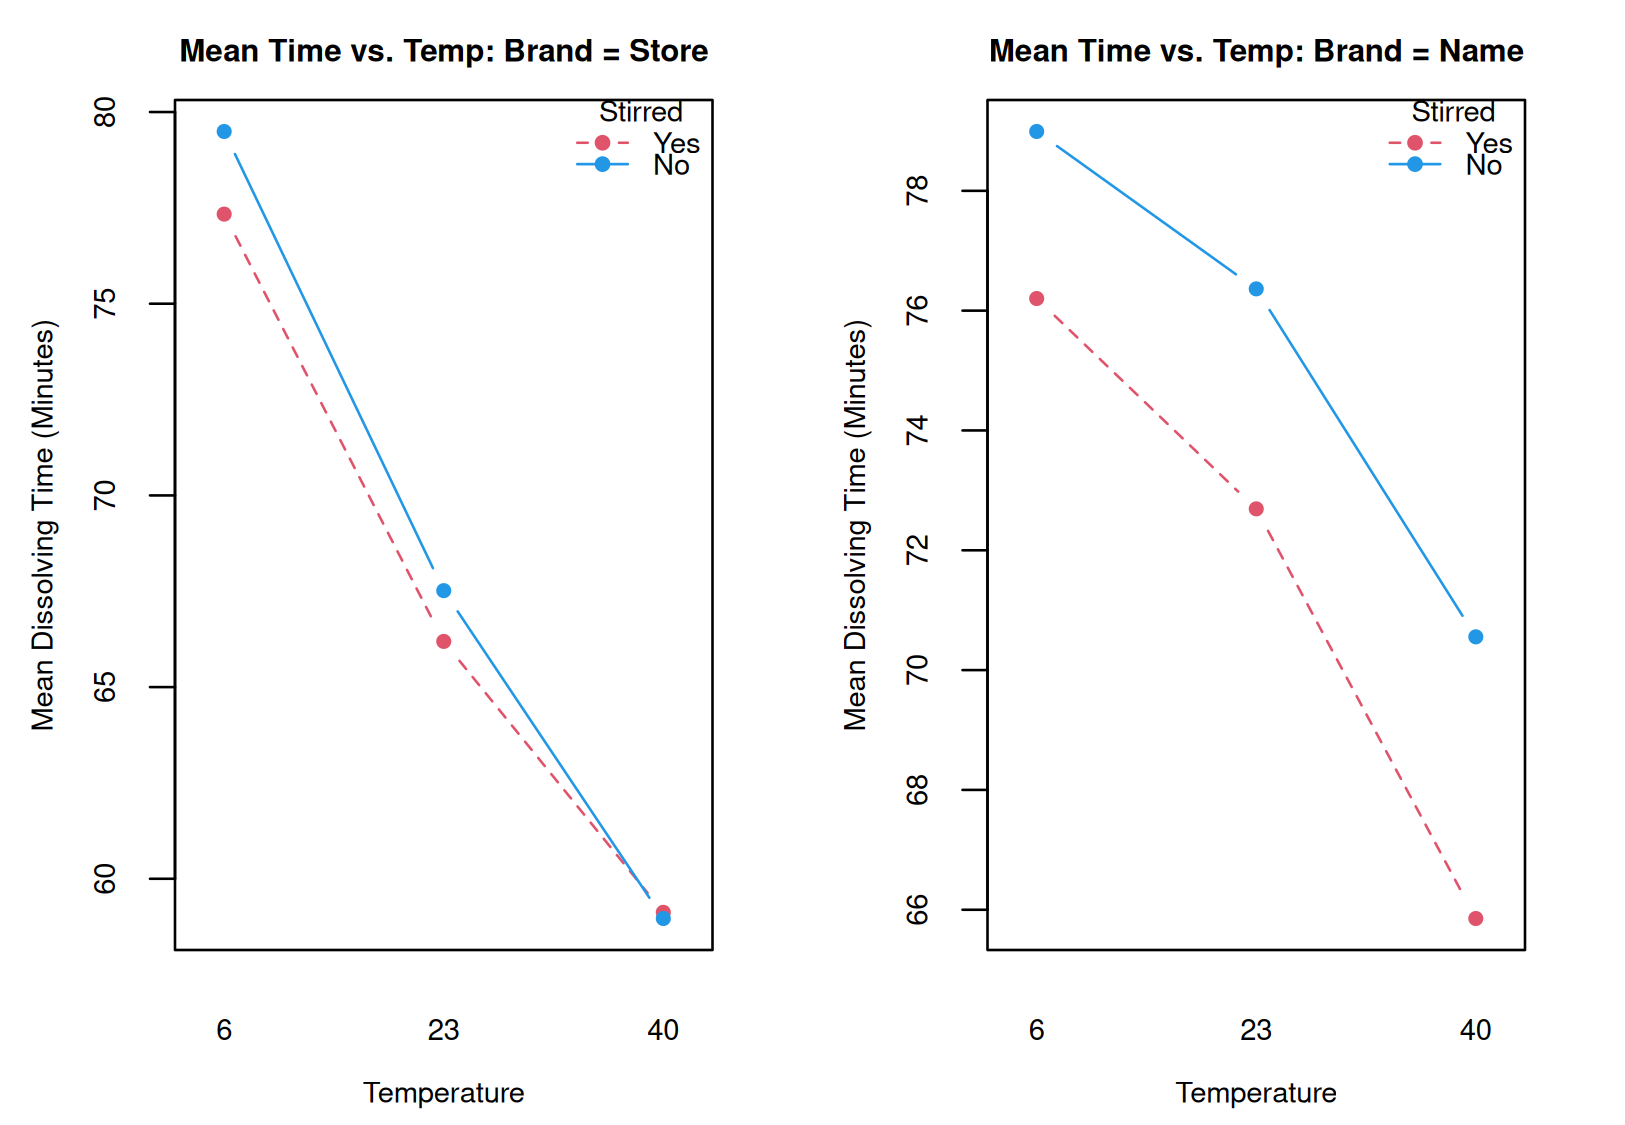

In [31]:
par(mfrow=c(1,2), mar = c(3.5,3.5,2,2))
with(df_eff%>%filter(Brand=="store"),interaction.plot(Temp,Stirred,Time,
            type="b", pch=20, col=c(2,4), ylab="", xlab = "",
            main="Mean Time vs. Temp: Brand = Store", 
            cex.main = 0.75, cex.axis = 0.7, legend = FALSE))
legend("topright",
       title = "Stirred",
       c("Yes", "No"),
       bty = "n",
       cex = 0.7,
       col = c("#DF536B","#2297E6"),
       pch = c(19,19), lty = c(2,1))
title(xlab = "Temperature", ylab = "Mean Dissolving Time (Minutes)", line = 2.25, cex.lab = 0.7)

with(df_eff%>%filter(Brand=="name"),interaction.plot(Temp,Stirred,Time,
          type="b", pch=20, col=c(2,4), ylab="", xlab = "",
          main="Mean Time vs. Temp: Brand = Name", 
          cex.main = 0.75, cex.axis = 0.7, legend = FALSE))
legend("topright",
       title = "Stirred",
       c("Yes", "No"),
       bty = "n",
       cex = 0.7,
       col = c("#DF536B","#2297E6"),
       pch = c(19,19), lty = c(2,1))
title(xlab = 'Temperature', ylab = "Mean Dissolving Time (Minutes)", line = 2.25, cex.lab = 0.7)

In [32]:
df_eff %>% filter(Brand == 'store') %>% group_by(Temp, Stirred) %>% 
summarise('Mean' = mean(Time), 'Var' = var(Time), 'Max' = max(Time), 'Min' = min(Time), 'Spread' = Max - Min) %>% kable()

df_eff %>% filter(Brand == 'name') %>% group_by(Temp, Stirred) %>% 
summarise('Mean' = mean(Time), 'Var' = var(Time), 'Max' = max(Time), 'Min' = min(Time), 'Spread' = Max - Min) %>% kable()

`summarise()` has grouped output by 'Temp'. You can override using the
`.groups` argument.




|Temp |Stirred |     Mean|       Var|      Max|      Min|    Spread|
|:----|:-------|--------:|---------:|--------:|--------:|---------:|
|6    |yes     | 77.33703| 0.5964884| 77.89089| 76.24402| 1.6468708|
|6    |no      | 79.49240| 1.6942517| 80.92176| 77.78345| 3.1383169|
|23   |yes     | 66.19126| 0.0411024| 66.38436| 65.92809| 0.4562787|
|23   |no      | 67.51552| 0.2060739| 67.93138| 67.08353| 0.8478521|
|40   |yes     | 59.12529| 0.4320148| 59.82388| 58.24407| 1.5798100|
|40   |no      | 58.96347| 0.1202191| 59.33370| 58.53920| 0.7945066|

`summarise()` has grouped output by 'Temp'. You can override using the
`.groups` argument.




|Temp |Stirred |     Mean|       Var|      Max|      Min|   Spread|
|:----|:-------|--------:|---------:|--------:|--------:|--------:|
|6    |yes     | 76.20241| 0.4593492| 77.21547| 75.80973| 1.405738|
|6    |no      | 78.99061| 0.4146440| 79.72130| 78.15246| 1.568833|
|23   |yes     | 72.69145| 6.9869087| 75.37855| 69.08937| 6.289179|
|23   |no      | 76.36351| 0.1078134| 76.83265| 76.06895| 0.763694|
|40   |yes     | 65.85343| 2.5499751| 68.08492| 64.45156| 3.633354|
|40   |no      | 70.55511| 0.2544033| 71.20207| 69.99943| 1.202643|

In [33]:
1 - pf(19, 2, 2)

[1] 0.05

In [34]:
qf(0.95, 2, 2)

[1] 19

In [35]:
qf(0.95, 2, 42)

[1] 3.219942

In [36]:
me_table

Source,Df,Sum Sq,Mean Sq,Error Term,Error Df,F Score,Pr>F
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
Brand,1,97.50550,97.505504,MSA,2,2.434286,0.2591
Temp,2,815.90352,407.951760,MSB,2,10.184770,0.0894
Brand*Temp,2,80.11016,40.055078,MSAB,18,21.718234,0.0000
Residual,18,33.19752,1.844306,MSE,NA,NA,NA


print(means_stir)

In [37]:
var_table <- df_eff %>% group_by(Brand, Temp, Stirred) %>% summarise('Var' = var(Time))
#var_table
#knitr::kable(quantile(var_table$Var))

var_table$Group <- ifelse(var_table$Brand == 'name' & var_table$Stirred == 'yes', 'Stirred Brand',
                          ifelse(var_table$Brand == 'name' & var_table$Stirred == 'no', 'Non Stirred Brand',
                                 ifelse(var_table$Brand == 'store' & var_table$Stirred == 'yes', 'Stirred Store',
                                        ifelse(var_table$Brand == 'store' & var_table$Stirred == 'no', 'Non Stirred Store', NA))))
var_table
                                        


`summarise()` has grouped output by 'Brand', 'Temp'. You can override using the
`.groups` argument.


Brand,Temp,Stirred,Var,Group
<fct>,<fct>,<fct>,<dbl>,<chr>
name,6,yes,0.45934925,Stirred Brand
name,6,no,0.41464405,Non Stirred Brand
name,23,yes,6.98690870,Stirred Brand
name,23,no,0.10781342,Non Stirred Brand
name,40,yes,2.54997510,Stirred Brand
name,40,no,0.25440333,Non Stirred Brand
store,6,yes,0.59648839,Stirred Store
store,6,no,1.69425169,Non Stirred Store
store,23,yes,0.04110242,Stirred Store


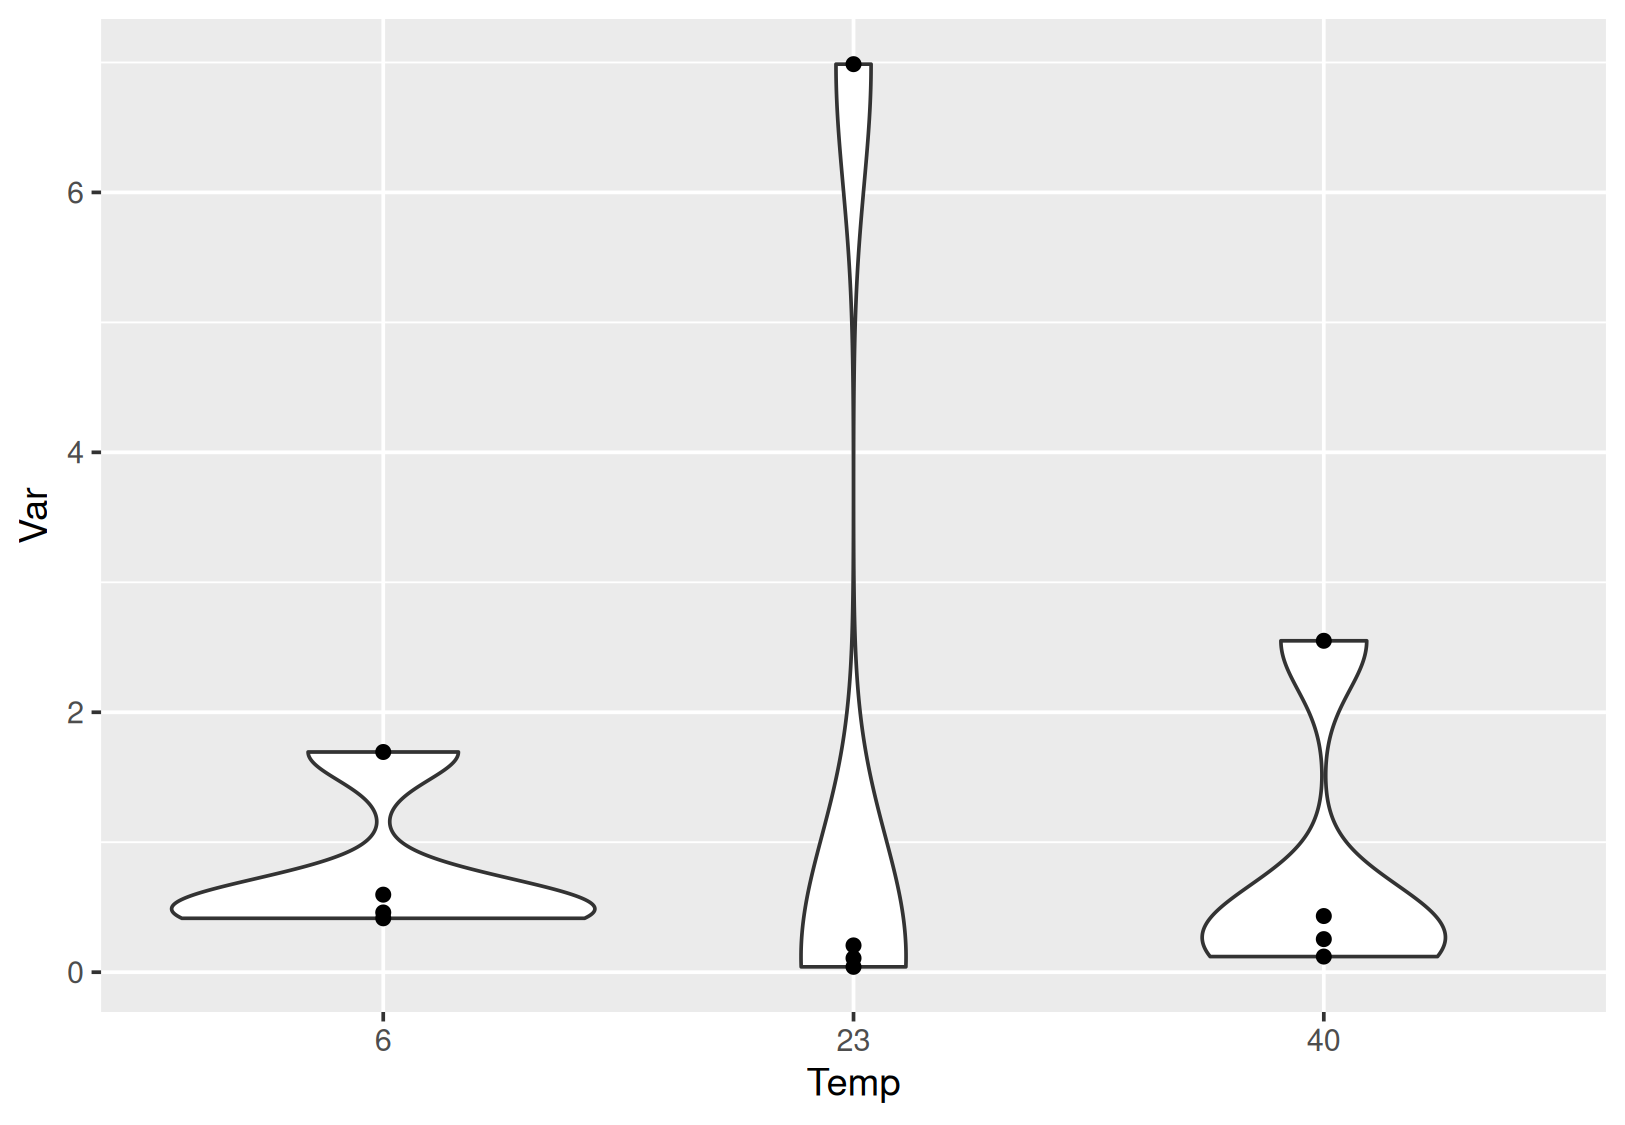

In [38]:
ggplot(var_table) + geom_violin(aes(x = Temp, y = Var)) + geom_point(aes(x = Temp, y = Var))

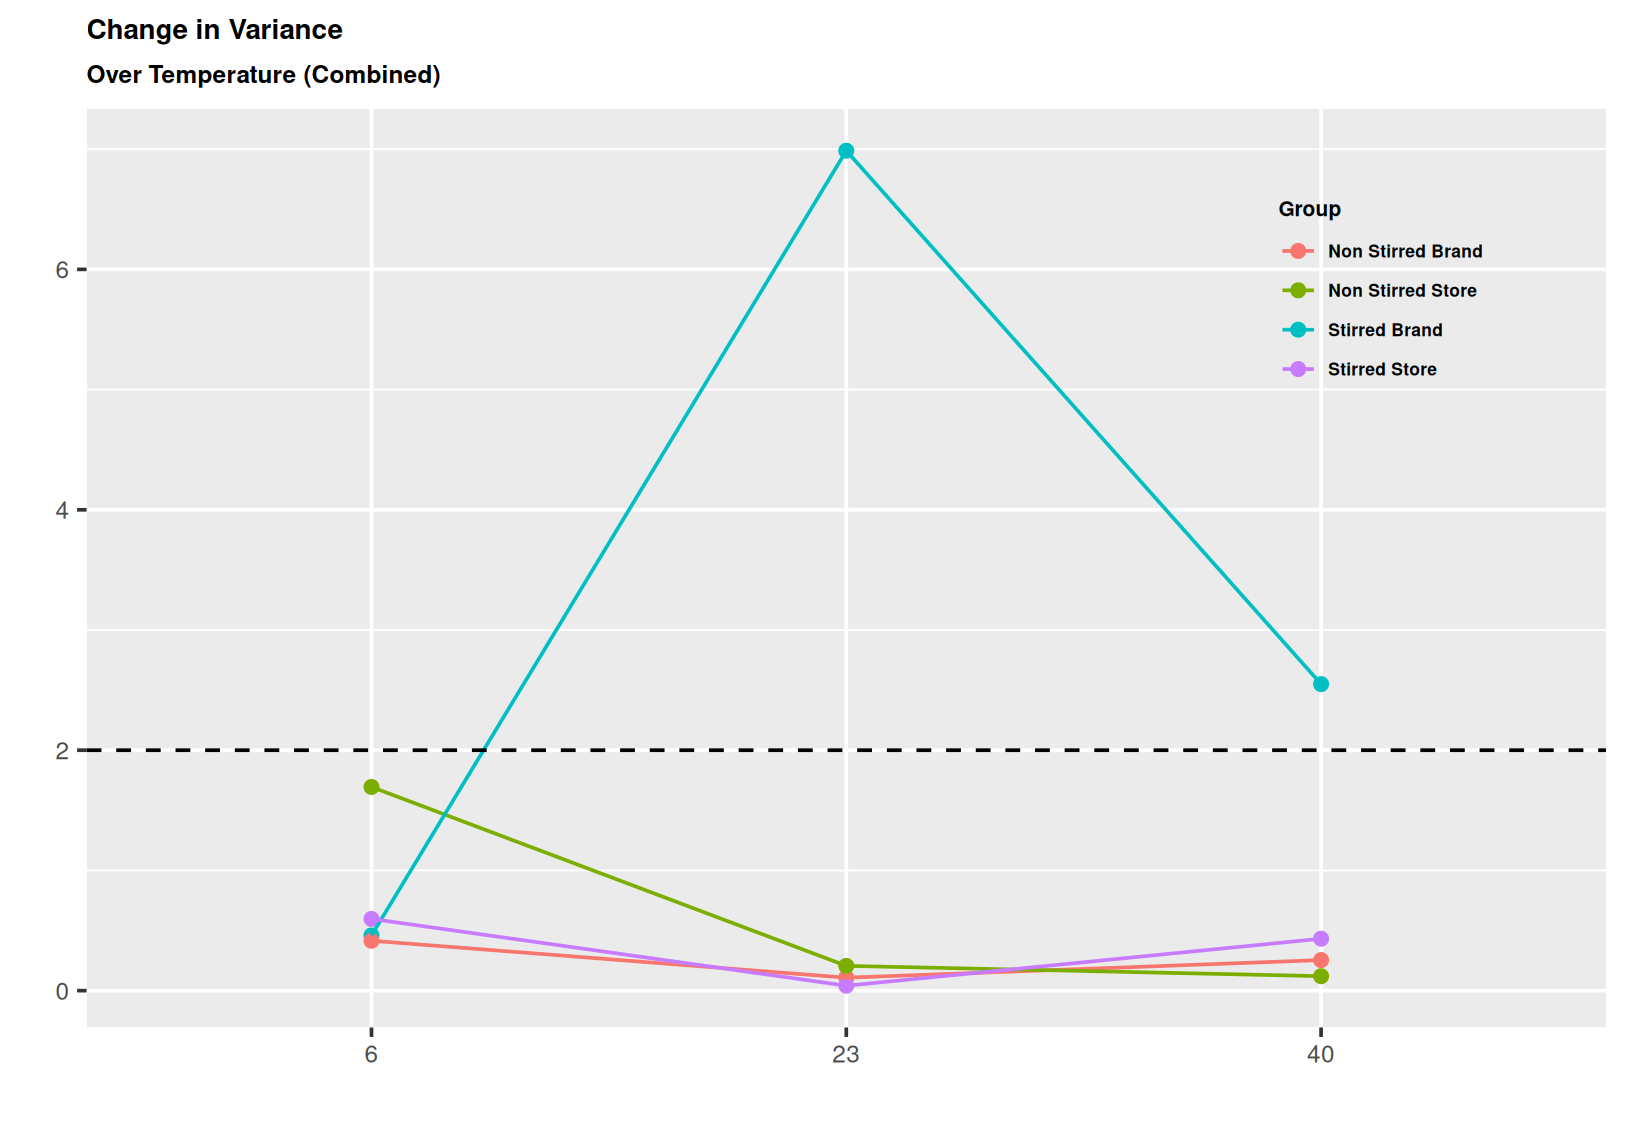

In [39]:
ggplot(var_table) + geom_point(aes(x = Temp, y = Var, col = Group)) + 
    geom_line(aes(x = Temp, y = Var, col = Group, group = Group)) +
    geom_hline(yintercept = 2, lty = 'dashed') +
         labs(title = "Change in Variance",
              subtitle = "Over Temperature (Combined)",
              x = '',
              y = '') +
         theme(legend.position = c(0.85, 0.8),
               plot.title = element_text(size = 8, face = "bold"),
               plot.subtitle = element_text(size = 7, face = "bold"),
               axis.text = element_text(size = 7),
               axis.title = element_text(size = 8),
               legend.text = element_text(size=5, face="bold"),
               legend.title = element_text(size=6, face="bold"),
               legend.key.size = unit(0.4, 'cm'),
               legend.key = element_rect(colour = "transparent", fill = alpha("white", 0)),
               legend.background = element_rect(fill = alpha("white", 0)))

`summarise()` has grouped output by 'Brand'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'Brand'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'Brand'. You can override using the
`.groups` argument.


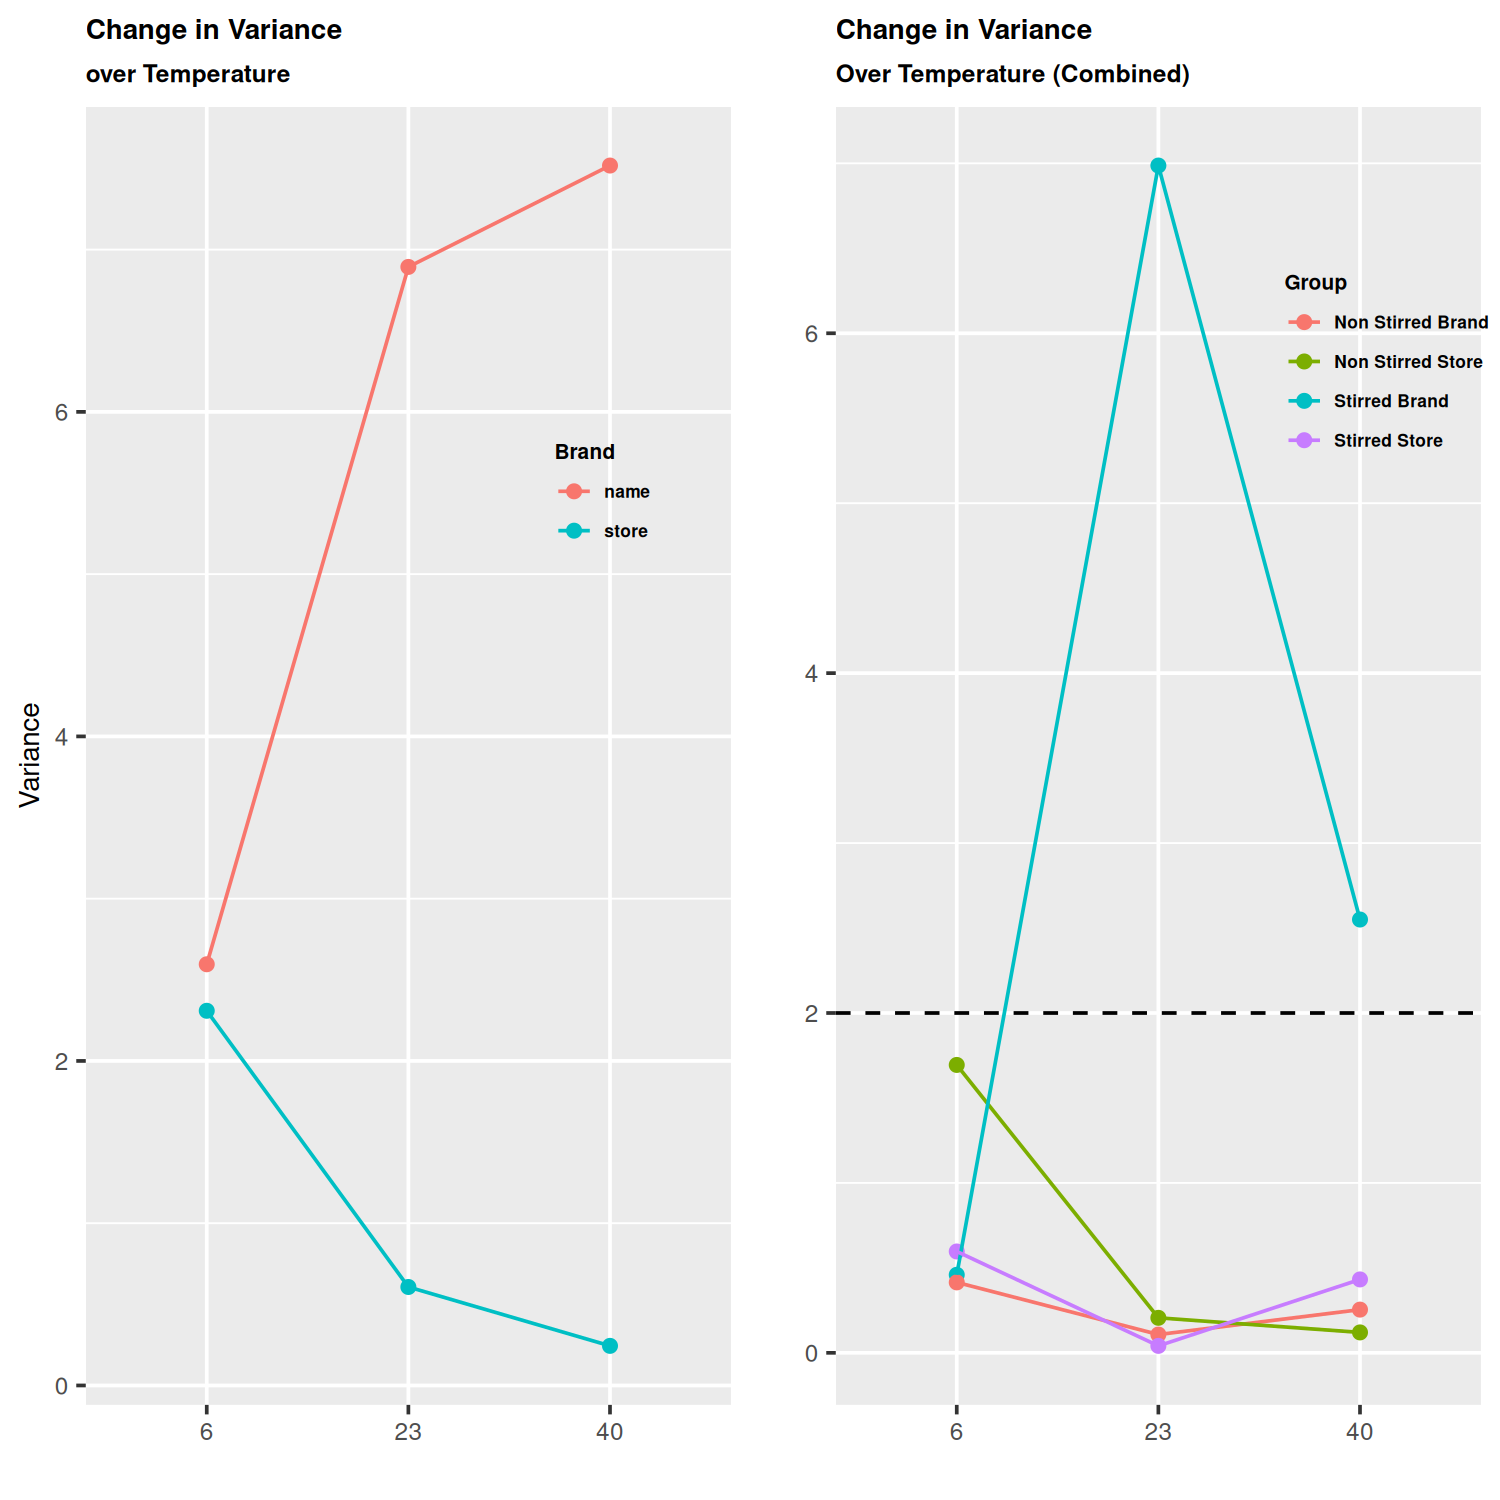

In [40]:
options(repr.plot.width = 6, repr.plot.height = 6, repr.plot.res = 250)

change_var <-
df_eff %>% group_by(Brand, Temp) %>% summarise('Mean' = mean(Time), 
                                               'Var' = var(Time), 
                                               'Max' = max(Time), 
                                               'Min' = min(Time), 
                                               'Spread' = Max - Min)
change_varplot <-
ggplot(change_var) + geom_point(aes(x = Temp, y = Var, col = Brand)) +
                     geom_line(aes(x = Temp, y = Var, col = Brand, group = Brand)) + 
                     labs(title = "Change in Variance",
                          subtitle = "over Temperature",
                          x = '',
                          y = 'Variance') +
                     theme(legend.position = c(0.8, 0.7),
                           plot.title = element_text(size = 8, face = "bold"),
                           plot.subtitle = element_text(size = 7, face = "bold"),
                           axis.text = element_text(size = 7),
                           axis.title = element_text(size = 8),
                           legend.text = element_text(size=5, face="bold"),
                           legend.title = element_text(size=6, face="bold"),
                           legend.key.size = unit(0.4, 'cm'),
               legend.key = element_rect(colour = "transparent", fill = alpha("white", 0)),
               legend.background = element_rect(fill = alpha("white", 0)))

change_var2 <-
df_eff %>% filter(Stirred == "yes") %>% group_by(Brand, Temp) %>% summarise('Mean' = mean(Time), 
                                               'Var' = var(Time), 
                                               'Max' = max(Time), 
                                               'Min' = min(Time), 
                                               'Spread' = Max - Min)
change_var2plot <-
ggplot(change_var2) + geom_point(aes(x = Temp, y = Var, col = Brand)) +
                     geom_line(aes(x = Temp, y = Var, col = Brand, group = Brand)) + 
                     labs(title = "Change in Variance",
                          subtitle = "Over Temperature (Stirred)",
                          x = '',
                          y = '') +
                     theme(legend.position = c(0.85, 0.8),
                           plot.title = element_text(size = 8, face = "bold"),
                           plot.subtitle = element_text(size = 7, face = "bold"),
                           axis.text = element_text(size = 7),
                           axis.title = element_text(size = 8),
                           legend.text = element_text(size=5, face="bold"),
                           legend.title = element_text(size=6, face="bold"),
                           legend.key.size = unit(0.4, 'cm'),
               legend.key = element_rect(colour = "transparent", fill = alpha("white", 0)),
               legend.background = element_rect(fill = alpha("white", 0)))

change_var3 <-
df_eff %>% filter(Stirred == "no") %>% group_by(Brand, Temp) %>% summarise('Mean' = mean(Time), 
                                               'Var' = var(Time), 
                                               'Max' = max(Time), 
                                               'Min' = min(Time), 
                                               'Spread' = Max - Min)
change_var3plot <-
ggplot(change_var3) + geom_point(aes(x = Temp, y = Var, col = Brand)) +
                     geom_line(aes(x = Temp, y = Var, col = Brand, group = Brand)) + 
                     labs(title = "Change in Variance",
                          subtitle = "over Temperature (Not Stirred)",
                          x = '',
                          y = '') +
                     theme(legend.position = c(0.85, 0.8),
                           plot.title = element_text(size = 8, face = "bold"),
                           plot.subtitle = element_text(size = 7, face = "bold"),
                           axis.text = element_text(size = 7),
                           axis.title = element_text(size = 8),
                           legend.text = element_text(size=5, face="bold"),
                           legend.title = element_text(size=6, face="bold"),
                           legend.key.size = unit(0.4, 'cm'),
                           legend.key = element_rect(colour = "transparent", fill = alpha("white", 0)),
                           legend.background = element_rect(fill = alpha("white", 0)))

change_var4plot <- 
ggplot(var_table) + geom_point(aes(x = Temp, y = Var, col = Group)) + 
    geom_line(aes(x = Temp, y = Var, col = Group, group = Group)) +
    geom_hline(yintercept = 2, lty = 'dashed') +
         labs(title = "Change in Variance",
              subtitle = "Over Temperature (Combined)",
              x = '',
              y = '') +
         theme(legend.position = c(0.85, 0.8),
               plot.title = element_text(size = 8, face = "bold"),
               plot.subtitle = element_text(size = 7, face = "bold"),
               axis.text = element_text(size = 7),
               axis.title = element_text(size = 8),
               legend.text = element_text(size=5, face="bold"),
               legend.title = element_text(size=6, face="bold"),
               legend.key.size = unit(0.4, 'cm'),
               legend.key = element_rect(colour = "transparent", fill = alpha("white", 0)),
               legend.background = element_rect(fill = alpha("white", 0)))

plot_grid(change_varplot,change_var4plot,change_var2plot, change_var3plot, nrow = 1 , ncol = 2)

In [41]:
library(lmerTest)
model_mixed <- lmer(Time ~ Brand + (1|Temp) + (1|Brand:Temp), df_eff)

Loading required package: lme4

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack



Attaching package: ‘lmerTest’


The following object is masked from ‘package:lme4’:

    lmer


The following object is masked from ‘package:stats’:

    step




In [42]:
anova(model_mixed)

,Sum Sq,Mean Sq,NumDF,DenDF,F value,Pr(>F)
,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
Brand,9.916145,9.916145,1,2,2.95022,0.2280042


In [43]:
summary(model_mixed)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: Time ~ Brand + (1 | Temp) + (1 | Brand:Temp)
   Data: df_eff

REML criterion at convergence: 210.8

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.94794 -0.48858  0.00233  0.74896  1.64953 

Random effects:
 Groups     Name        Variance Std.Dev.
 Brand:Temp (Intercept) 14.071   3.751   
 Temp       (Intercept) 44.465   6.668   
 Residual                3.361   1.833   
Number of obs: 48, groups:  Brand:Temp, 6; Temp, 3

Fixed effects:
            Estimate Std. Error     df t value Pr(>|t|)   
(Intercept)   73.443      4.433  2.550  16.567  0.00116 **
Brandstore    -5.339      3.108  2.000  -1.718  0.22800   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
           (Intr)
Brandstore -0.351

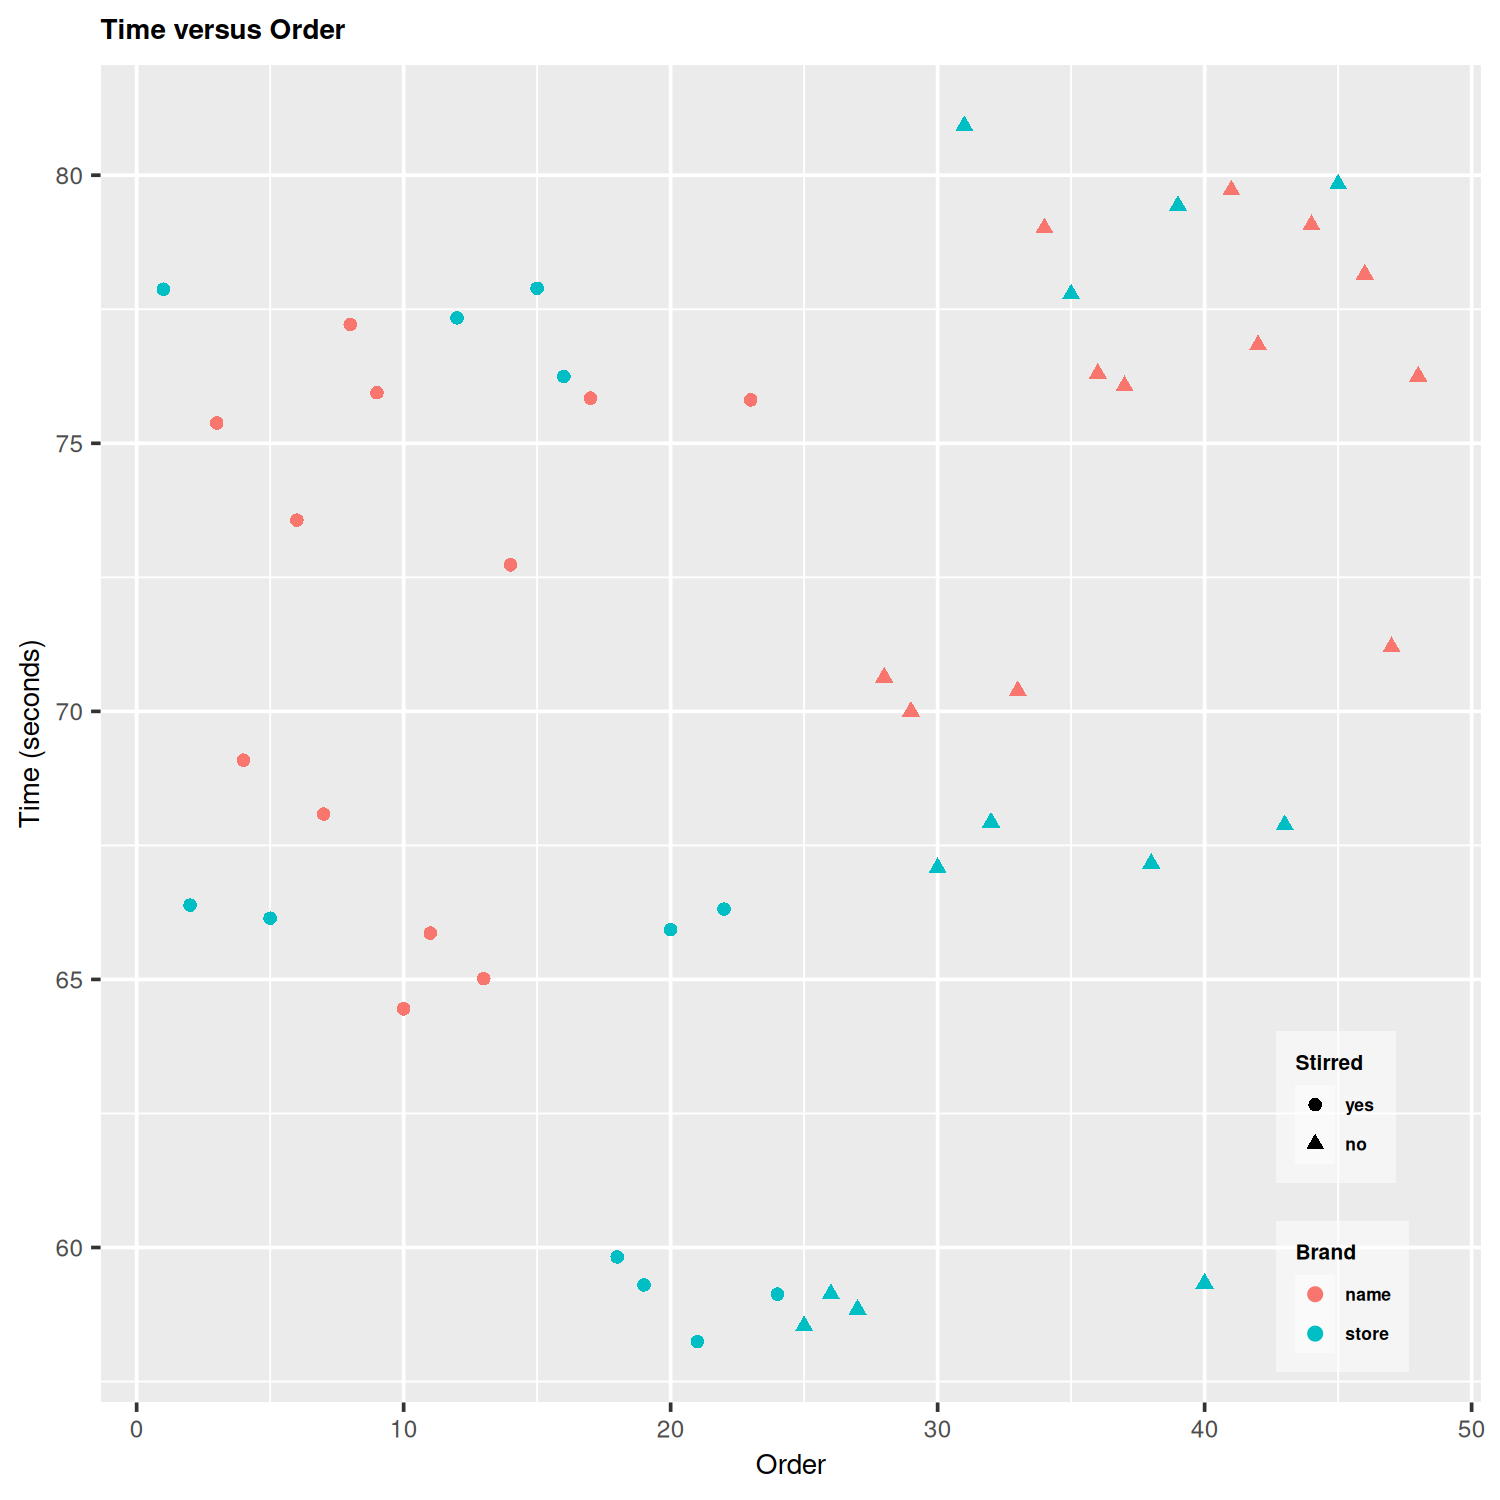

In [69]:
ggplot(df_eff) + geom_point(aes(x = Order, y = Time, col = Brand, pch = Stirred)) +
 labs(title = "Time versus Order",
              x = 'Order',
              y = 'Time (seconds)') +
         theme(legend.position = c(0.9, 0.15),
               plot.title = element_text(size = 8, face = "bold"),
               plot.subtitle = element_text(size = 7, face = "bold"),
               axis.text = element_text(size = 7),
               axis.title = element_text(size = 8),
               legend.text = element_text(size=5, face="bold"),
               legend.title = element_text(size=6, face="bold"),
               legend.key.size = unit(0.4, 'cm'),
               legend.key = element_rect( fill = alpha("white", 0.5)),
               legend.background = element_rect(fill = alpha("white", 0.5)))

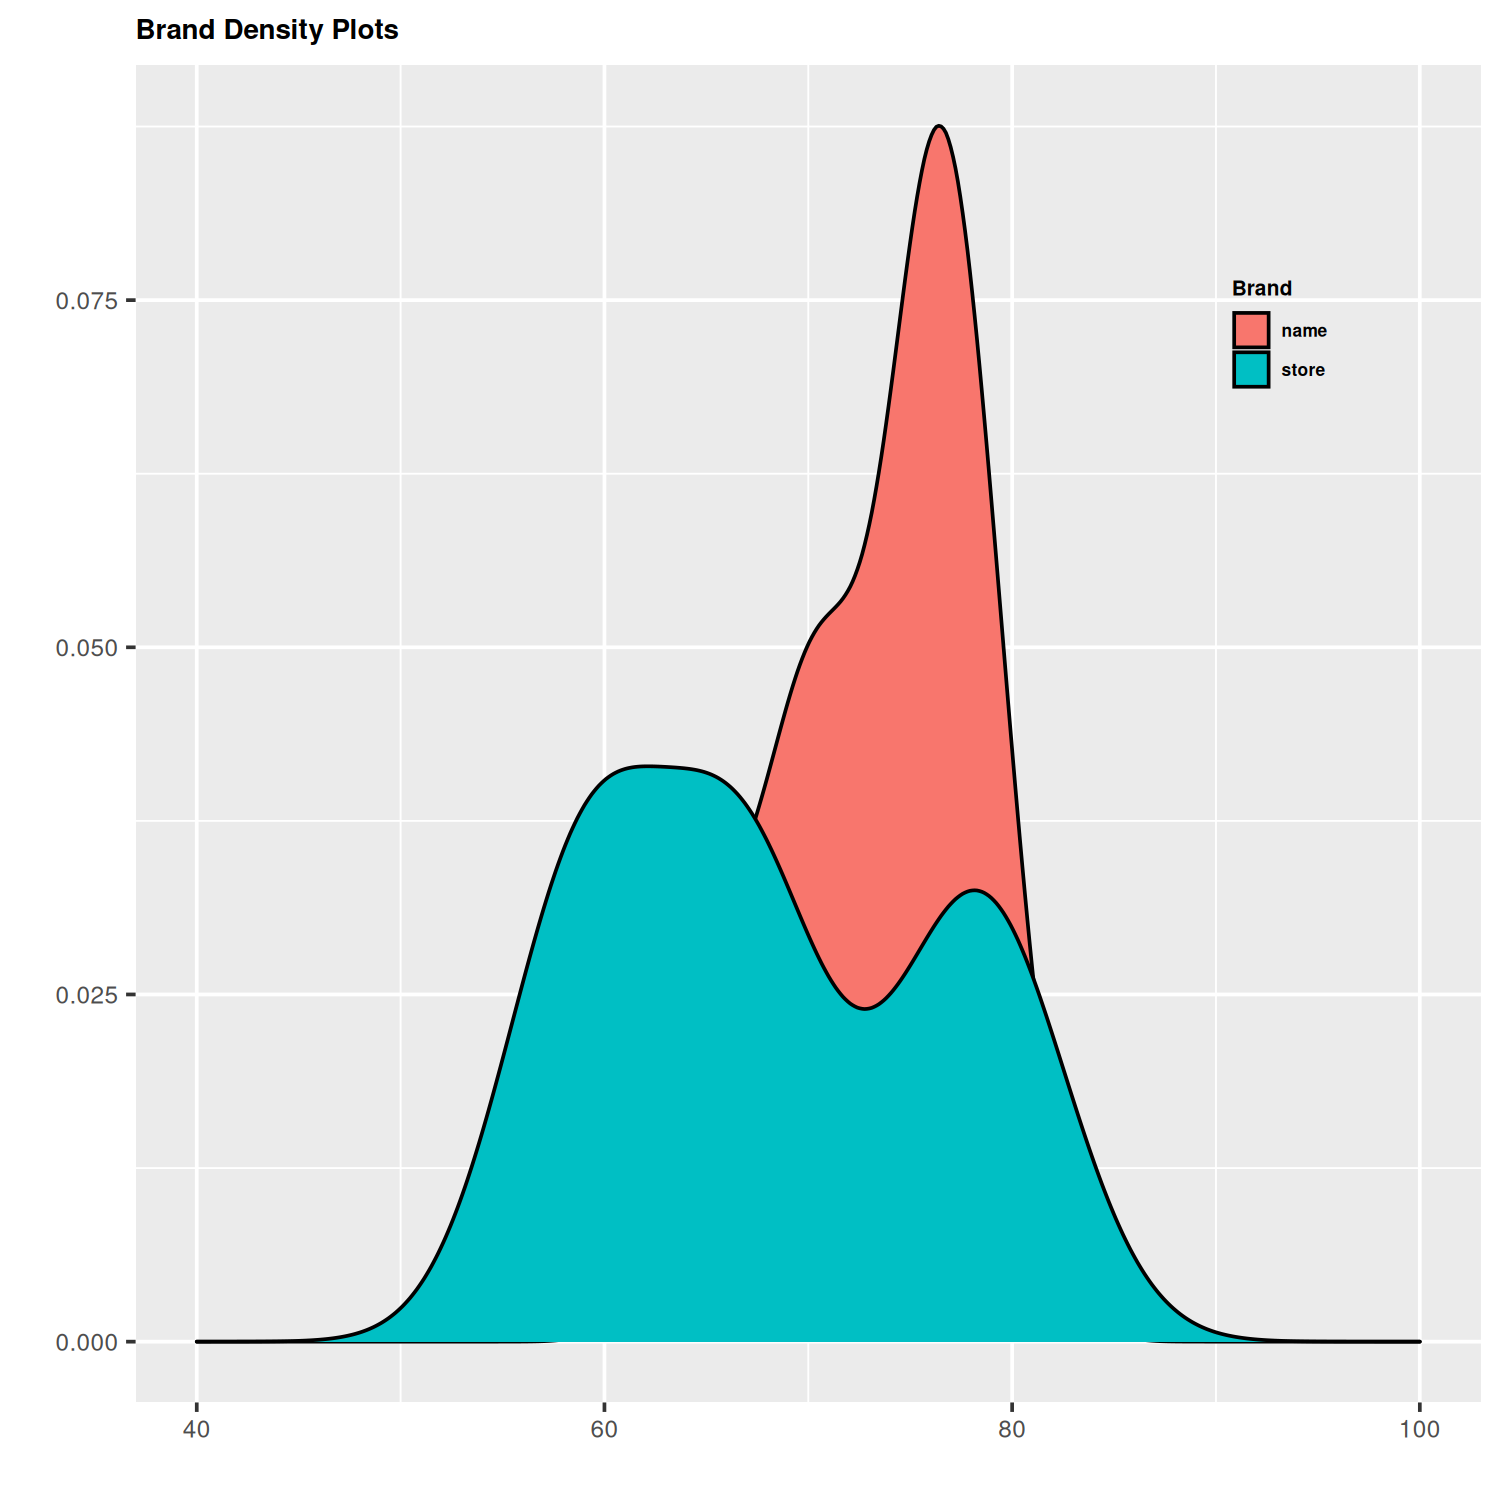

In [58]:
ggplot(df_eff) + geom_density(aes(Time, fill = Brand), adjust = 1) + xlim(c(40, 100)) +
 labs(title = "Brand Density Plots",
              x = '',
              y = '') +
         theme(legend.position = c(0.85, 0.8),
               plot.title = element_text(size = 8, face = "bold"),
               plot.subtitle = element_text(size = 7, face = "bold"),
               axis.text = element_text(size = 7),
               axis.title = element_text(size = 8),
               legend.text = element_text(size=5, face="bold"),
               legend.title = element_text(size=6, face="bold"),
               legend.key.size = unit(0.4, 'cm'),
               legend.key = element_rect(colour = "transparent", fill = alpha("white", 0)),
               legend.background = element_rect(fill = alpha("white", 0)))

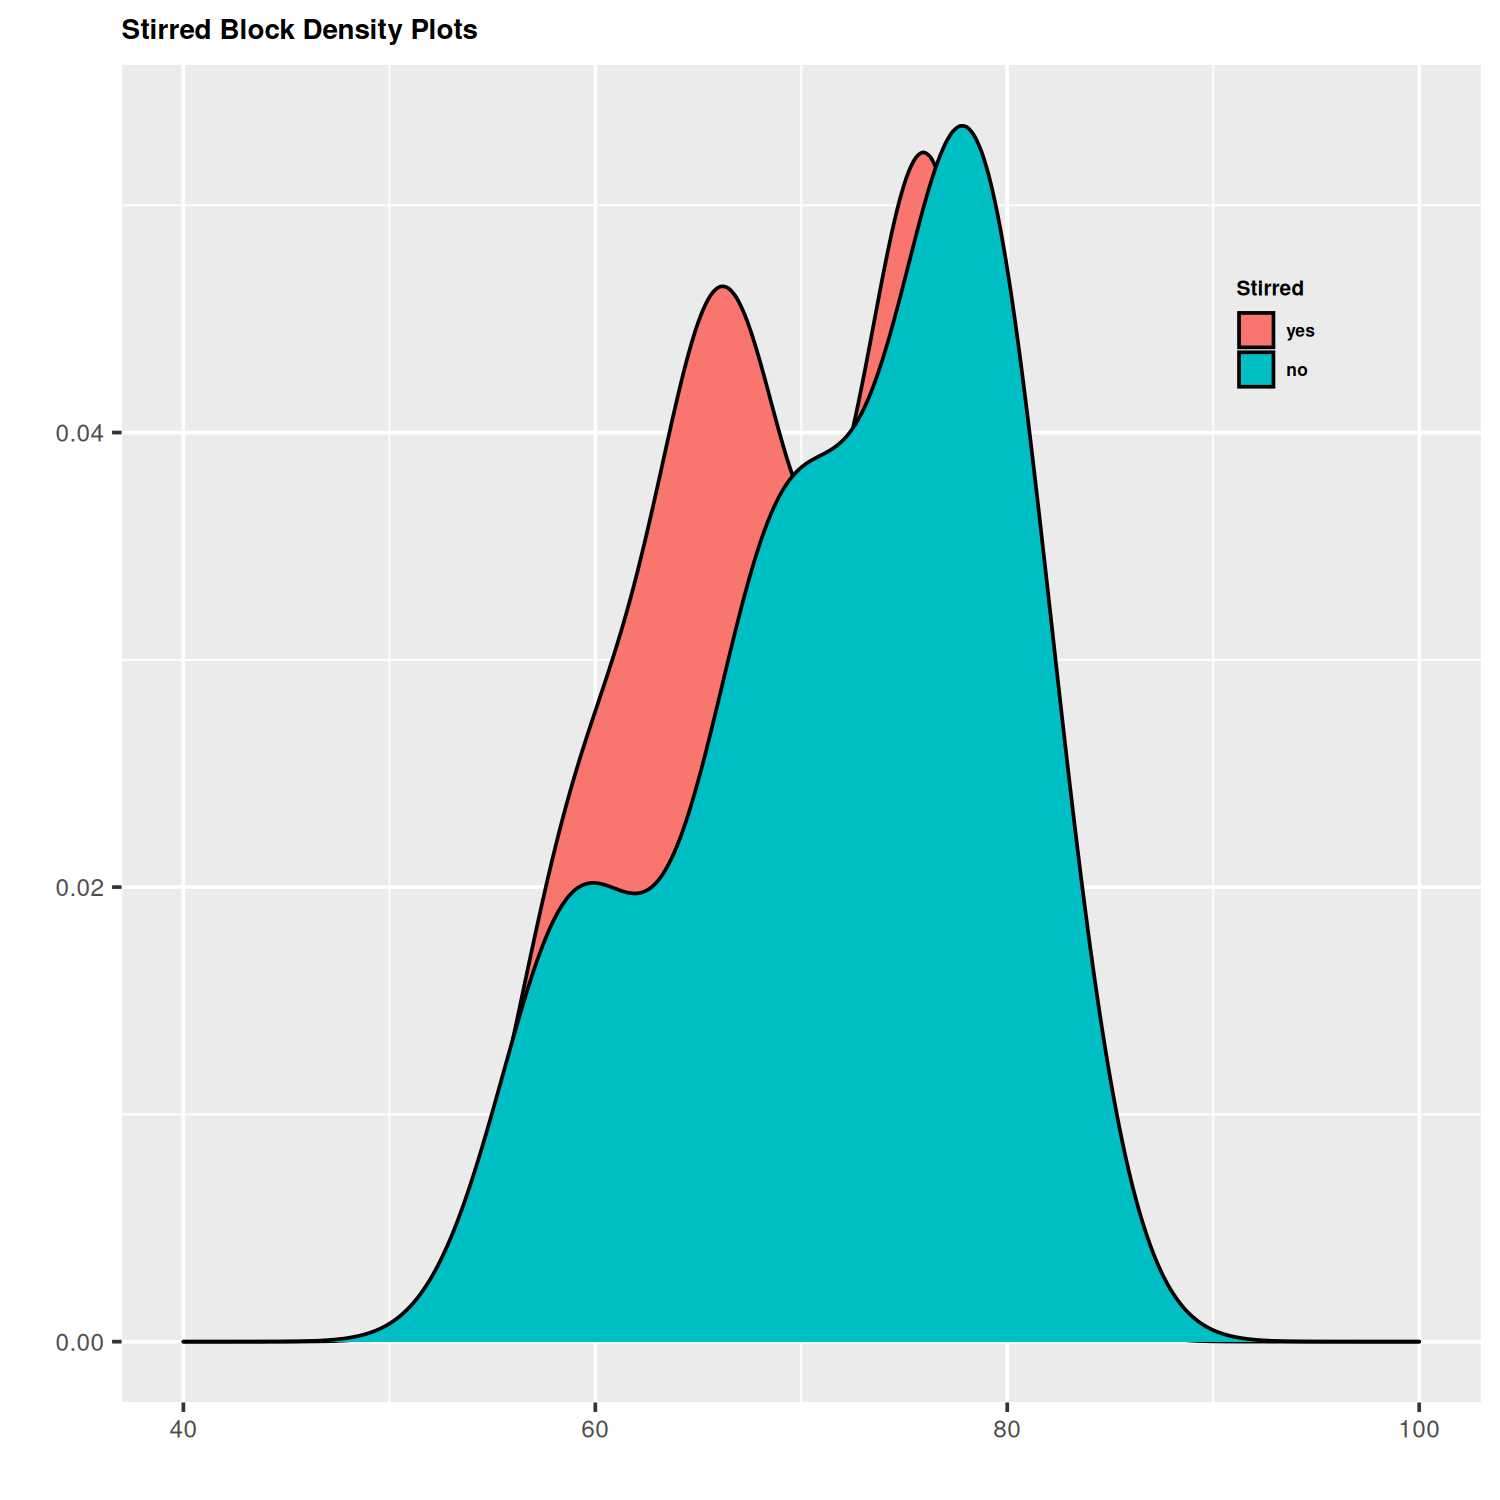

In [60]:
ggplot(df_eff) + geom_density(aes(Time, fill = Stirred), adjust = 1) + xlim(c(40, 100)) +
 labs(title = "Stirred Block Density Plots",
              x = '',
              y = '') +
         theme(legend.position = c(0.85, 0.8),
               plot.title = element_text(size = 8, face = "bold"),
               plot.subtitle = element_text(size = 7, face = "bold"),
               axis.text = element_text(size = 7),
               axis.title = element_text(size = 8),
               legend.text = element_text(size=5, face="bold"),
               legend.title = element_text(size=6, face="bold"),
               legend.key.size = unit(0.4, 'cm'),
               legend.key = element_rect(colour = "transparent", fill = alpha("white", 0)),
               legend.background = element_rect(fill = alpha("white", 0)))

In [72]:
library(lmtest)
bptest(aov_eff)


	studentized Breusch-Pagan test

data:  aov_eff
BP = 20.151, df = 11, p-value = 0.04331


`geom_smooth()` using formula 'y ~ x'



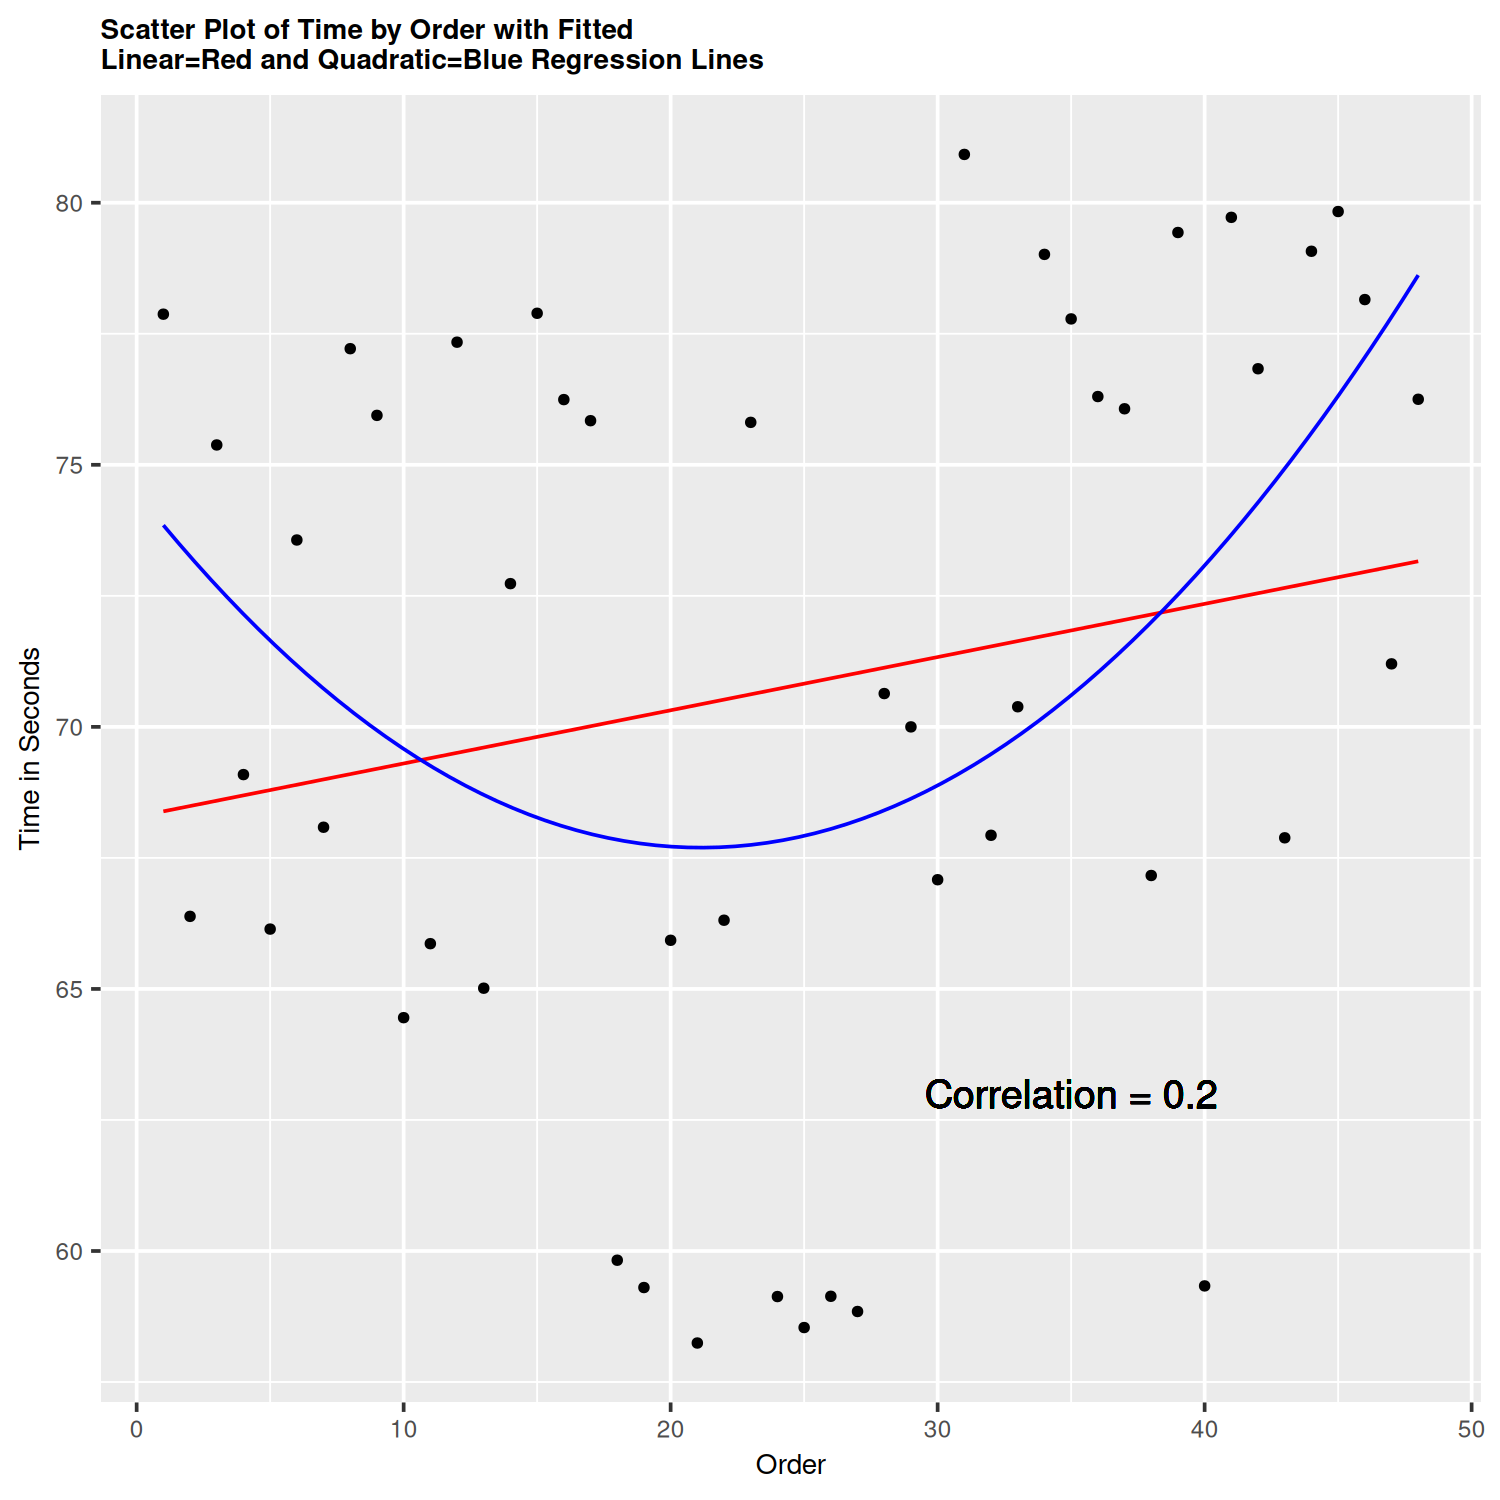

In [83]:
correlation <- cor(df_eff$Time,df_eff$Order)

##construct scatter plot of Time by Order with fitted SLR line
## add correlation result to this plot
gOrderTime <- ggplot(df_eff,aes(x=Order,y=Time))
gOrderTime + 
    geom_point(pch = 20) + geom_smooth(method = lm, col = "Red", se = F, size = 0.5) + 
    geom_text(x = 35, y = 63, size = 4, label = paste0("Correlation = ",round(correlation, 2))) +  
    geom_smooth(method = lm, formula = y~poly(x,2), col="Blue", se = F, size = 0.5) + 
    
    labs(title = "Scatter Plot of Time by Order with Fitted \nLinear=Red and Quadratic=Blue Regression Lines",
             x = 'Order',
             y = 'Time in Seconds') +
    theme(legend.position = c(0.85, 0.8),
          plot.title = element_text(size = 8, face = "bold"),
          plot.subtitle = element_text(size = 7, face = "bold"),
          axis.text = element_text(size = 7),
          axis.title = element_text(size = 8),
          legend.text = element_text(size=5, face="bold"),
          legend.title = element_text(size=6, face="bold"),
          legend.key.size = unit(0.4, 'cm'),
          legend.key = element_rect(colour = "transparent", fill = alpha("white", 0)),
          legend.background = element_rect(fill = alpha("white", 0)))

In [84]:
qf(0.95, 11, 36)

[1] 2.066608

In [88]:
print(Anova(aov_eff, type = 3))

Anova Table (Type III tests)

Response: Time
                    Sum Sq Df    F value    Pr(>F)    
(Intercept)        23227.2  1 20105.4508 < 2.2e-16 ***
Brand                  2.6  1     2.2287 0.1441852    
Temp                 221.6  2    95.9006 3.780e-15 ***
Stirred               15.5  1    13.4584 0.0007832 ***
Brand:Temp            80.1  2    34.6716 4.041e-09 ***
Brand:Stirred          0.4  1     0.3466 0.5596939    
Temp:Stirred           3.7  2     1.5877 0.2183718    
Brand:Temp:Stirred     9.1  2     3.9195 0.0288376 *  
Residuals             41.6 36                         
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [91]:
sum(Anova(aov_eff, type = 3)[[1]][2:8])

[1] 332.9403